# Phaeocystis pathway analysis
In this notebook, we'll analyze the pathways expressed by Phaeocystis globosa. Specifically, we're interested in cyclic patterns, carbohydrate production, etc. 
First we'll extract transcripts annotated to Phaeocystis globosa, combine them with functional information, gene expression info and metadata.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import seaborn as sns
import time
from goatools.obo_parser import GODag
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

## Data preparation

In [3]:
# Read transcripts annotated to Phaeocystis (from the output of the mtx_taxonomy.ipynb script)
phaeocystis_transcripts = pd.read_csv("../data/annotation/taxonomy_eukprot/130/genus_bins/Phaeocystis_transcriptome_bin.csv")
print(len(phaeocystis_transcripts))
# Filter out transcripts annotated to Phaeocystis globosa with a percent identity above 80
phaeocystis_transcripts = phaeocystis_transcripts[(phaeocystis_transcripts["p_ident"] > 0.8) & (phaeocystis_transcripts["Name_to_Use"] == "Phaeocystis globosa")]
print(len(phaeocystis_transcripts))

# Keep only the transcript IDs
phaeocystis_transcripts = phaeocystis_transcripts["query_id"].tolist()

357651
97536


In [4]:
# Read in the functional annotation data
functional_annotation = pd.read_table('../data/annotation/functional_eggnog/130/functional_annotation.emapper.annotations', )
# Cut off weird characters from the transcript names
functional_annotation['#query'] = functional_annotation['#query'].str.split(".", n=1, expand=True)[0]
# Rename the query_id column
functional_annotation.rename(columns={'#query': 'transcript_id'}, inplace=True)
print(len(functional_annotation))
# Only keep the rows that are in the Phaeocystis transcriptome
functional_annotation = functional_annotation[functional_annotation['transcript_id'].isin(phaeocystis_transcripts)]
print(len(functional_annotation))

674375
61277


In [5]:
# Read in the quantification data
tpl = pd.read_csv('../data/quantification/130/130_tpl.csv')

# Rename the target_id column
tpl.rename(columns={'target_id': 'transcript_id'}, inplace=True)

# Change into long format
tpl = tpl.melt(id_vars=['transcript_id'], var_name='sample', value_name='TPL')

# Only keep the rows that are in the Phaeocystis transcriptome
tpl = tpl[tpl['transcript_id'].isin(phaeocystis_transcripts)]

## Generate Phaeocystis TPL sums per sample
phaeo_tpl_sums = tpl.groupby('sample')['TPL'].sum().reset_index()

## Rename columns
phaeo_tpl_sums.columns = ['sample', 'Phaeocystis_total_TPL']

In [6]:
# Read in the environmental data
env_data = pd.read_csv('../data/samples_env.csv', index_col=0)
# Read in primary production data
PP_data = pd.read_csv('../data/raw/LabSTAF/labstaf_combined_data.csv')
## Combine Station and Sample columns into one station_sample column
PP_data['Station'] = PP_data['Station'].astype(str) + '_' + PP_data['Sample'].astype(str)

# Merge PP_data with env and transcript data
env_data = env_data.merge(PP_data[['Station', 'PP']], on=['Station'], how='inner')

# Rename station column
env_data.rename(columns={'Station': 'sample'}, inplace=True)

print(env_data.columns)

Index(['sample', 'StationPrefix', 'StationSuffix', 'Latitude', 'Longitude',
       'Date', 'day_moment', 'day_length', 'Temperature', 'Salinity',
       'Conductivity', 'Depth', 'Oxygen', 'Fluorescence', 'NH4', 'NO2', 'NO3',
       'NOX', 'PO4', 'Si', 'TEP', 'sea_surface_height_above_sea_level',
       'surface_baroclinic_sea_water_velocity', 'PP'],
      dtype='object')


In [7]:
# Create a dataframe containing the sample names, functional annotation categories of interest and TPL
functional_columns = ['transcript_id', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'PFAMs', 'GOs', 'Description']
data = functional_annotation[functional_columns].merge(tpl, on='transcript_id', how='inner')
data = data.merge(env_data, on='sample', how='inner')

# Standardize the TPL values per sample by dividing by the total TPL of Phaeocystis in that sample
data = data.merge(phaeo_tpl_sums, on='sample', how='inner')
data['TPL_standardized'] = data['TPL'] / data['Phaeocystis_total_TPL']

data.head()

transcript_id              KEGG_ko  \
0  c_000001019834  ko:K05282,ko:K05841   
1  c_000001019834  ko:K05282,ko:K05841   
2  c_000001019834  ko:K05282,ko:K05841   
3  c_000001019834  ko:K05282,ko:K05841   
4  c_000001019834  ko:K05282,ko:K05841   

                                        KEGG_Pathway KEGG_Module     PFAMs  \
0  ko00904,ko01100,ko01110,map00904,map01100,map0...           -  C2,UDPGT   
1  ko00904,ko01100,ko01110,map00904,map01100,map0...           -  C2,UDPGT   
2  ko00904,ko01100,ko01110,map00904,map01100,map0...           -  C2,UDPGT   
3  ko00904,ko01100,ko01110,map00904,map01100,map0...           -  C2,UDPGT   
4  ko00904,ko01100,ko01110,map00904,map01100,map0...           -  C2,UDPGT   

  GOs                                        Description sample       TPL  \
0   -  transferase activity, transferring hexosyl groups  130_1  0.000000   
1   -  transferase activity, transferring hexosyl groups  130_2  0.000000   
2   -  transferase activity, transferring hexosyl groups  130_3  0.000000   
3   -  transferase activity, transferring hexosyl groups  130_4  0.000000   
4   -  transferase activity, transferring hexosyl groups  130_5  6.351163   

   StationPrefix  ...    NO3    NOX   PO4     Si          TEP  \
0            130  ...  12.96  13.34  0.05  13.20  1286.832000   
1            130  ...  14.91  15.25  0.06  13.29  1202.172000   
2            130  ...  17.44  17.81  0.05  14.30  1326.340000   
3            130  ...  15.94  16.29  0.05  13.36  1083.648000   
4            130  ...  17.13  17.43  0.05  12.82  1728.945333   

   sea_surface_height_above_sea_level  surface_baroclinic_sea_water_velocity  \
0                           -1.802973                               0.543319   
1                           -1.069393                               0.562920   
2                           -0.290541                               0.361021   
3                            1.187761                               0.338537   
4                            2.587380                               0.865567   

       PP  Phaeocystis_total_TPL  TPL_standardized  
0  356.76           5.184154e+05      0.000000e+00  
1  231.00           3.638961e+06      0.000000e+00  
2  224.76           4.158762e+06      0.000000e+00  
3  235.20           9.959761e+06      0.000000e+00  
4  411.48           4.167282e+07      1.524054e-07  

[5 rows x 34 columns]

In [8]:
# Export a matrix with phaeocystis KEGG KO expression values (standardized by total Phaeocystis TPL) across samples
export = data[data['KEGG_ko'] != '-'][['sample', 'KEGG_ko', 'TPL_standardized']]

# split the KEGG KO column values into a list of KOs
export['KEGG_ko'] = export['KEGG_ko'].str.split(',')
# Explode the KO column
export = export.explode('KEGG_ko')
# Group by KO and sample and sum the TPL values
export = export.groupby(['KEGG_ko', 'sample'])['TPL_standardized'].sum().reset_index()
# Remove weird characters from the KO column
export['KEGG_ko'] = export['KEGG_ko'].str.split(":", n=1, expand=True)[1]

# Pivot the table
export = export.pivot(index='KEGG_ko', columns='sample', values='TPL_standardized')

# Fill NaN values with 0
export.fillna(0, inplace=True)

# Export the matrix
export.to_csv('../data/analysis/130_phaeo_KO_TPL_standardized_expression.csv')

In [9]:
export.head()

sample      130_1    130_10    130_11    130_12    130_13    130_14    130_15  \
KEGG_ko                                                                         
K00001   0.000060  0.000000  0.000010  0.000000  0.000000  0.000000  0.000034   
K00002   0.000079  0.000070  0.000118  0.000120  0.000152  0.000069  0.000126   
K00003   0.000202  0.000824  0.000477  0.000341  0.000297  0.000272  0.000289   
K00006   0.000885  0.000276  0.000192  0.000233  0.000298  0.000340  0.000411   
K00010   0.000000  0.000095  0.000002  0.000110  0.000073  0.000034  0.000000   

sample     130_16    130_17    130_18  ...    130_23    130_24    130_25  \
KEGG_ko                                ...                                 
K00001   0.000000  0.000047  0.000026  ...  0.000000  0.000000  0.000005   
K00002   0.000000  0.000127  0.000102  ...  0.000036  0.000045  0.000098   
K00003   0.000229  0.000296  0.000099  ...  0.000053  0.000040  0.000155   
K00006   0.001024  0.001090  0.001537  ...  0.001277  0.001438  0.000933   
K00010   0.000000  0.000045  0.000000  ...  0.000145  0.000069  0.000178   

sample      130_3     130_4     130_5     130_6     130_7     130_8     130_9  
KEGG_ko                                                                        
K00001   0.000005  0.000035  0.000065  0.000000  0.000000  0.000000  0.000005  
K00002   0.000093  0.000038  0.000036  0.000117  0.000094  0.000176  0.000070  
K00003   0.000373  0.000286  0.000305  0.000413  0.000262  0.000582  0.001007  
K00006   0.002155  0.002532  0.001462  0.001244  0.002380  0.000681  0.000317  
K00010   0.000070  0.000054  0.000054  0.000067  0.000092  0.000000  0.000073  

[5 rows x 25 columns]

## KEGG Pathways

In [10]:
# Remove the 'ko:' prefix and split multiple KOs
data['KEGG_ko_clean'] = data['KEGG_ko'].str.replace("ko:", "").str.split(',')

# Explode the dataframe to have one KO per row (duplicating TPL values accordingly)
data_exploded = data.explode('KEGG_ko_clean')

# Inspect the data
data.head()

transcript_id              KEGG_ko  \
0  c_000001019834  ko:K05282,ko:K05841   
1  c_000001019834  ko:K05282,ko:K05841   
2  c_000001019834  ko:K05282,ko:K05841   
3  c_000001019834  ko:K05282,ko:K05841   
4  c_000001019834  ko:K05282,ko:K05841   

                                        KEGG_Pathway KEGG_Module     PFAMs  \
0  ko00904,ko01100,ko01110,map00904,map01100,map0...           -  C2,UDPGT   
1  ko00904,ko01100,ko01110,map00904,map01100,map0...           -  C2,UDPGT   
2  ko00904,ko01100,ko01110,map00904,map01100,map0...           -  C2,UDPGT   
3  ko00904,ko01100,ko01110,map00904,map01100,map0...           -  C2,UDPGT   
4  ko00904,ko01100,ko01110,map00904,map01100,map0...           -  C2,UDPGT   

  GOs                                        Description sample       TPL  \
0   -  transferase activity, transferring hexosyl groups  130_1  0.000000   
1   -  transferase activity, transferring hexosyl groups  130_2  0.000000   
2   -  transferase activity, transferring hexosyl groups  130_3  0.000000   
3   -  transferase activity, transferring hexosyl groups  130_4  0.000000   
4   -  transferase activity, transferring hexosyl groups  130_5  6.351163   

   StationPrefix  ...    NOX   PO4     Si          TEP  \
0            130  ...  13.34  0.05  13.20  1286.832000   
1            130  ...  15.25  0.06  13.29  1202.172000   
2            130  ...  17.81  0.05  14.30  1326.340000   
3            130  ...  16.29  0.05  13.36  1083.648000   
4            130  ...  17.43  0.05  12.82  1728.945333   

  sea_surface_height_above_sea_level  surface_baroclinic_sea_water_velocity  \
0                          -1.802973                               0.543319   
1                          -1.069393                               0.562920   
2                          -0.290541                               0.361021   
3                           1.187761                               0.338537   
4                           2.587380                               0.865567   

       PP  Phaeocystis_total_TPL  TPL_standardized     KEGG_ko_clean  
0  356.76           5.184154e+05      0.000000e+00  [K05282, K05841]  
1  231.00           3.638961e+06      0.000000e+00  [K05282, K05841]  
2  224.76           4.158762e+06      0.000000e+00  [K05282, K05841]  
3  235.20           9.959761e+06      0.000000e+00  [K05282, K05841]  
4  411.48           4.167282e+07      1.524054e-07  [K05282, K05841]  

[5 rows x 35 columns]

In [11]:
# Obtain all the unique pathways from the data
# Step 1: Split the KEGG_Pathway column by commas to separate multiple entries
data['KEGG_Pathway_Split'] = data['KEGG_Pathway'].str.split(',')

# Step 2: Explode the dataframe to get one pathway per row
data_pathways = data.explode('KEGG_Pathway_Split')

# Step 3: Filter only the 'map' entries (which are pathway IDs)
data_pathways['KEGG_Pathway_Split'] = data_pathways['KEGG_Pathway_Split'].str.strip()  # Clean up any extra spaces
data_pathways = data_pathways[data_pathways['KEGG_Pathway_Split'].str.startswith('map')]

# Step 4: Extract unique pathway IDs
unique_pathways = data_pathways['KEGG_Pathway_Split'].unique()


In [12]:
# Function to fetch KO data for a specific pathway/module
def fetch_kos_for_pathway(pathway_id):
    # Use KEGG API to get the list of KOs for a pathway
    response = requests.get(f"http://rest.kegg.jp/link/ko/{pathway_id}")
    
    if response.status_code == 200:
        # Parse the response and extract KOs (check if line contains a tab)
        ko_list = [line.split('\t')[1].strip() for line in response.text.splitlines() if '\t' in line]
        return ko_list
    else:
        print(f"Failed to fetch data for {pathway_id} with status code {response.status_code}")
        return []

# Example pathway IDs from KEGG (you would replace these with your actual pathways of interest)
pathway_ids = unique_pathways

# Dictionary to store pathway names and associated KOs
pathway_module = {}

# Loop over pathway IDs and populate the dictionary
for pathway_id in pathway_ids:
    ko_list = fetch_kos_for_pathway(pathway_id)
    if ko_list:
        pathway_module[pathway_id] = ko_list

# Inspect the dictionary
print(pathway_module)

{'map00904': ['ko:K04120', 'ko:K04121', 'ko:K04122', 'ko:K04123', 'ko:K04124', 'ko:K04125', 'ko:K05282', 'ko:K12917', 'ko:K12918', 'ko:K12919', 'ko:K12920', 'ko:K12921', 'ko:K12922', 'ko:K12923', 'ko:K12924', 'ko:K12925', 'ko:K12926', 'ko:K12927', 'ko:K12928', 'ko:K12929', 'ko:K13070', 'ko:K14036', 'ko:K14037', 'ko:K14038', 'ko:K14039', 'ko:K14040', 'ko:K14041', 'ko:K14042', 'ko:K14043', 'ko:K14044', 'ko:K14045', 'ko:K14046', 'ko:K14047', 'ko:K16082', 'ko:K16083', 'ko:K16084', 'ko:K16085', 'ko:K16086', 'ko:K17961', 'ko:K17982', 'ko:K18113', 'ko:K19571', 'ko:K20512', 'ko:K20513', 'ko:K20514', 'ko:K20515', 'ko:K20516', 'ko:K20517', 'ko:K20518', 'ko:K20519', 'ko:K20657', 'ko:K20666', 'ko:K21291', 'ko:K21292', 'ko:K21718', 'ko:K21719', 'ko:K22634', 'ko:K22635', 'ko:K22636', 'ko:K22637', 'ko:K22638', 'ko:K22639', 'ko:K22640', 'ko:K22945', 'ko:K22946', 'ko:K22947', 'ko:K22948', 'ko:K24460', 'ko:K27636', 'ko:K27849', 'ko:K27850'], 'map01100': ['ko:K00001', 'ko:K00002', 'ko:K00003', 'ko:K00005

### Analysis

In [13]:
# Initialize a dataframe to hold the relative importance of each module per sample
module_importance = pd.DataFrame()

# Iterate through each module and sum the TPL_standardized values for the corresponding KOs
for module, ko_list in pathway_module.items():
    # Clean up the ko_list, remove ko: prefix
    ko_list = [ko.replace("ko:", "") for ko in ko_list]
    # Select the rows where the KO belongs to the current module's KO list
    module_data = data_exploded[data_exploded['KEGG_ko_clean'].isin(ko_list)]
    
    # Sum the standardized TPL for each sample for the given module
    module_sums = module_data.groupby('sample')['TPL_standardized'].sum().reset_index()
    
    # Rename the columns for clarity
    module_sums.columns = ['sample', f'{module}']
    
    # Merge with the main module_importance dataframe
    if module_importance.empty:
        module_importance = module_sums
    else:
        module_importance = module_importance.merge(module_sums, on='sample', how='outer')

# Inspect the module importance dataframe
module_importance.head()

sample  map00904  map01100  map01110  map03022  map05016  map05165  \
0   130_1  0.000331  0.159799  0.064022  0.001570  0.038990  0.011371   
1  130_10  0.000345  0.181426  0.091551  0.002427  0.045039  0.012069   
2  130_11  0.000334  0.167403  0.080615  0.002602  0.046161  0.012101   
3  130_12  0.000452  0.156085  0.074152  0.002237  0.048942  0.015228   
4  130_13  0.000345  0.169464  0.084101  0.002242  0.048340  0.014187   

   map05166  map05168  map05169  ...  map00941  map00944  map00945  map00532  \
0  0.011962  0.006532  0.013042  ...  0.000021  0.000021  0.000021  0.000000   
1  0.020064  0.008973  0.019364  ...  0.000000  0.000000  0.000000  0.000000   
2  0.015803  0.006183  0.016626  ...  0.000056  0.000056  0.000056  0.000000   
3  0.015416  0.006334  0.017730  ...  0.000043  0.000043  0.000043  0.000000   
4  0.016107  0.005970  0.017635  ...  0.000072  0.000072  0.000072  0.000005   

       map00966  map02060  map01501  map00901  map00522  map01057  
0  6.223277e-07       0.0  0.000000  0.000067       0.0       0.0  
1  9.164632e-05       0.0  0.000000  0.000000       0.0       0.0  
2  9.457405e-05       0.0  0.000000  0.000016       0.0       0.0  
3  8.943120e-05       0.0  0.000000  0.000000       0.0       0.0  
4  1.365181e-04       0.0  0.000005  0.000088       0.0       0.0  

[5 rows x 401 columns]

<Figure size 1000x600 with 0 Axes>

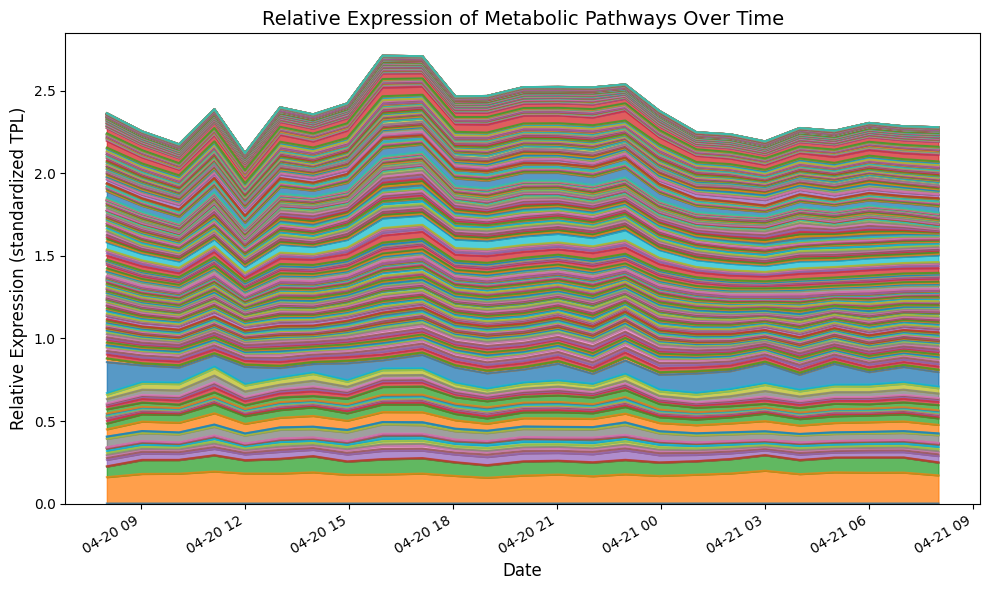

In [14]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Merge module_importance with env_data to include the Date column
module_importance_with_date = module_importance.merge(env_data[['sample', 'Date']], on='sample', how='left')

# Convert the Date column to datetime format for proper plotting
module_importance_with_date['Date'] = pd.to_datetime(module_importance_with_date['Date'])

# Sort the dataframe by Date for better visualization
module_importance_with_date = module_importance_with_date.sort_values(by='Date')
# Replace 0 with NaN in the standardized TPL values to interrupt the line plot
module_importance_with_date.replace(0, np.nan, inplace=True)

# Set the Date as the x-axis and plot the relative expression of each module
module_importance_with_date.set_index('Date', inplace=True)

# Plot a stacked area chart for relative expression
module_importance_with_date.iloc[:, 1:].plot(kind='area', stacked=True, figsize=(10, 6), alpha=0.75)

# Customize the plot for publication
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('Relative Expression of Metabolic Pathways Over Time', fontsize=14)
# Remove the legend 
plt.legend().set_visible(False)
plt.tight_layout()

# Save the plot as a publication-ready figure
#plt.savefig('pathway_module_expression_over_time.png', dpi=300)
plt.show()

Pathway map01232 - Nucleotide metabolism not found in the data
Pathway map01250 - Biosynthesis of nucleotide sugars not found in the data
Pathway map01240 - Biosynthesis of cofactors not found in the data
Pathway map01310 - Nitrogen cycle not found in the data


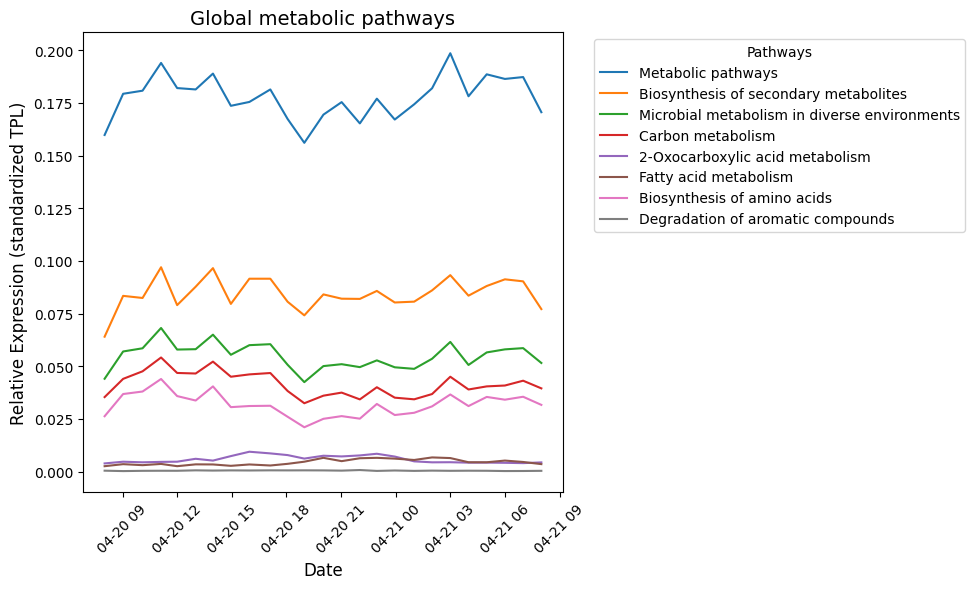

In [15]:
# Just include the global and overview maps
## Dictionary to store the global pathways
global_pathways = {
    "map01100": "Metabolic pathways",
    "map01110": "Biosynthesis of secondary metabolites",
    "map01120": "Microbial metabolism in diverse environments",
    "map01200": "Carbon metabolism",
    "map01210": "2-Oxocarboxylic acid metabolism",
    "map01212": "Fatty acid metabolism",
    "map01230": "Biosynthesis of amino acids",
    "map01232": "Nucleotide metabolism",
    "map01250": "Biosynthesis of nucleotide sugars",
    "map01240": "Biosynthesis of cofactors",
    "map01220": "Degradation of aromatic compounds",
    "map01310": "Nitrogen cycle"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in global_pathways.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('Global metabolic pathways', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

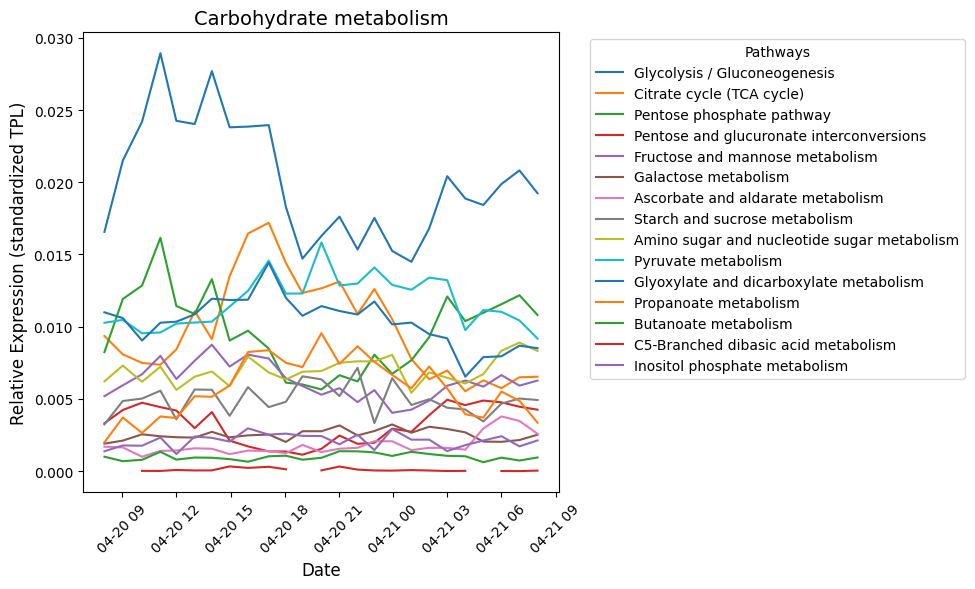

In [16]:
# Carbohydrate metabolism pathways
## Dictionary to store the carbohydrate pathways
carbohydrate_metabolism = {
"map00010": "Glycolysis / Gluconeogenesis",
"map00020": "Citrate cycle (TCA cycle)",
"map00030": "Pentose phosphate pathway",
"map00040": "Pentose and glucuronate interconversions",
"map00051": "Fructose and mannose metabolism",
"map00052": "Galactose metabolism",
"map00053": "Ascorbate and aldarate metabolism",
"map00500": "Starch and sucrose metabolism",
"map00520": "Amino sugar and nucleotide sugar metabolism",
"map00620": "Pyruvate metabolism",
"map00630": "Glyoxylate and dicarboxylate metabolism",
"map00640": "Propanoate metabolism",
"map00650": "Butanoate metabolism",
"map00660": "C5-Branched dibasic acid metabolism",
"map00562": "Inositol phosphate metabolism"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in carbohydrate_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('Carbohydrate metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

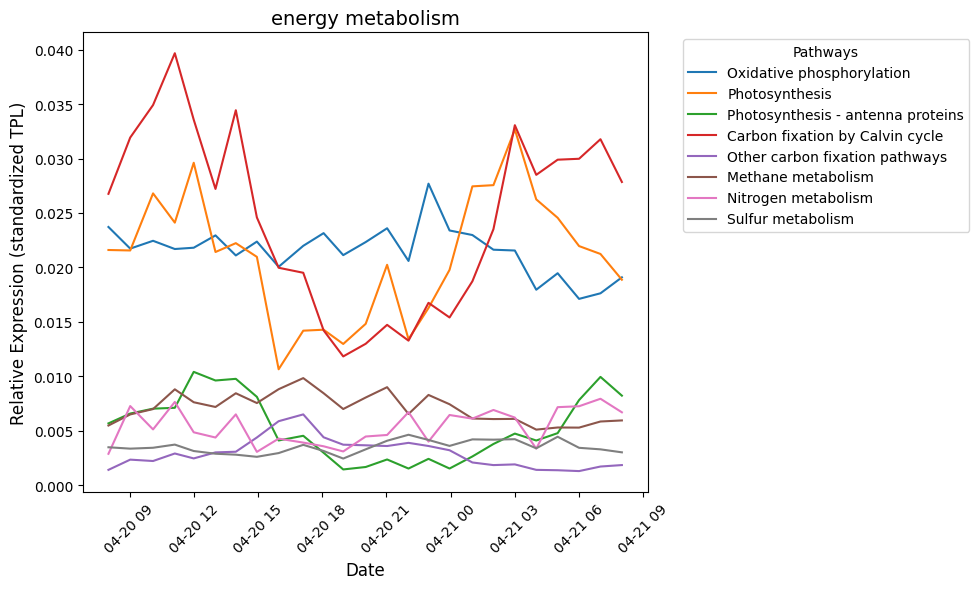

In [17]:
# energy metabolism pathways
## Dictionary to store the energy pathways
energy_metabolism = {
"map00190": "Oxidative phosphorylation", 
"map00195": "Photosynthesis", 
"map00196": "Photosynthesis - antenna proteins", 
"map00710": "Carbon fixation by Calvin cycle", 
"map00720": "Other carbon fixation pathways", 
"map00680": "Methane metabolism", 
"map00910": "Nitrogen metabolism", 
"map00920": "Sulfur metabolism"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in energy_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('energy metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map00074 - Mycolic acid biosynthesis New! not found in the data
Pathway map00121 - Secondary bile acid biosynthesis not found in the data


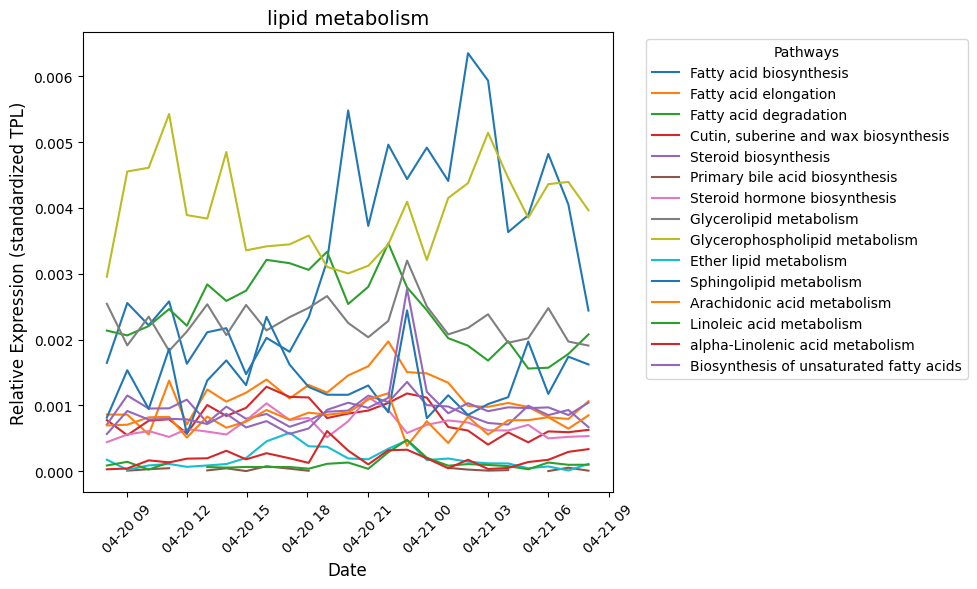

In [18]:
# lipid metabolism pathways
## Dictionary to store the lipid pathways
lipid_metabolism = {
"map00061": "Fatty acid biosynthesis",
"map00062": "Fatty acid elongation",
"map00071": "Fatty acid degradation",
"map00073": "Cutin, suberine and wax biosynthesis",
"map00074": "Mycolic acid biosynthesis New!",
"map00100": "Steroid biosynthesis",
"map00120": "Primary bile acid biosynthesis",
"map00121": "Secondary bile acid biosynthesis",
"map00140": "Steroid hormone biosynthesis",
"map00561": "Glycerolipid metabolism",
"map00564": "Glycerophospholipid metabolism",
"map00565": "Ether lipid metabolism",
"map00600": "Sphingolipid metabolism",
"map00590": "Arachidonic acid metabolism",
"map00591": "Linoleic acid metabolism",
"map00592": "alpha-Linolenic acid metabolism", 
"map01040": "Biosynthesis of unsaturated fatty acids"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in lipid_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('lipid metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()



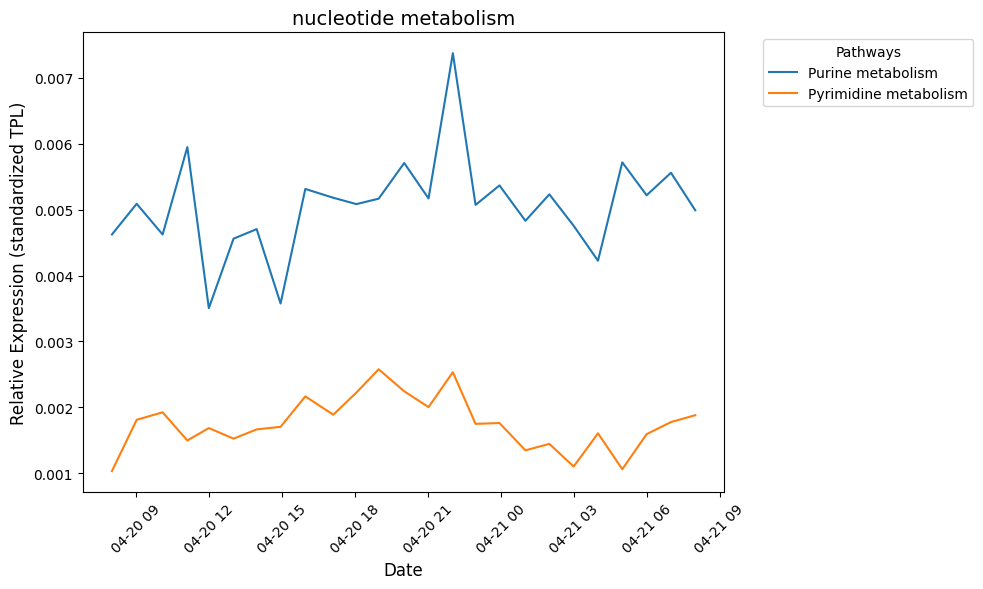

In [19]:
# nucleotide metabolism pathways
## Dictionary to store the nucleotide pathways
nucleotide_metabolism = {
"map00230": "Purine metabolism",
"map00240": "Pyrimidine metabolism"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in nucleotide_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('nucleotide metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()



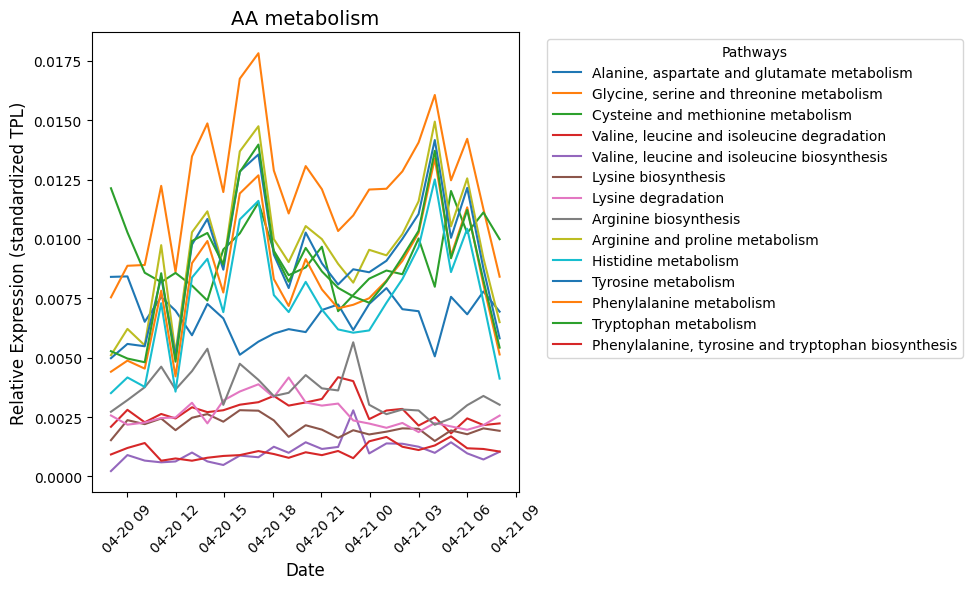

In [20]:
# AA metabolism pathways
## Dictionary to store the AA pathways
AA_metabolism = {
"map00250": "Alanine, aspartate and glutamate metabolism",
"map00260": "Glycine, serine and threonine metabolism",
"map00270": "Cysteine and methionine metabolism",
"map00280": "Valine, leucine and isoleucine degradation",
"map00290": "Valine, leucine and isoleucine biosynthesis",
"map00300": "Lysine biosynthesis",
"map00310": "Lysine degradation",
"map00220": "Arginine biosynthesis",
"map00330": "Arginine and proline metabolism",
"map00340": "Histidine metabolism",
"map00350": "Tyrosine metabolism",
"map00360": "Phenylalanine metabolism",
"map00380": "Tryptophan metabolism",
"map00400": "Phenylalanine, tyrosine and tryptophan biosynthesis"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in AA_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('AA metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()



Pathway map00470 - D-Amino acid metabolism not found in the data


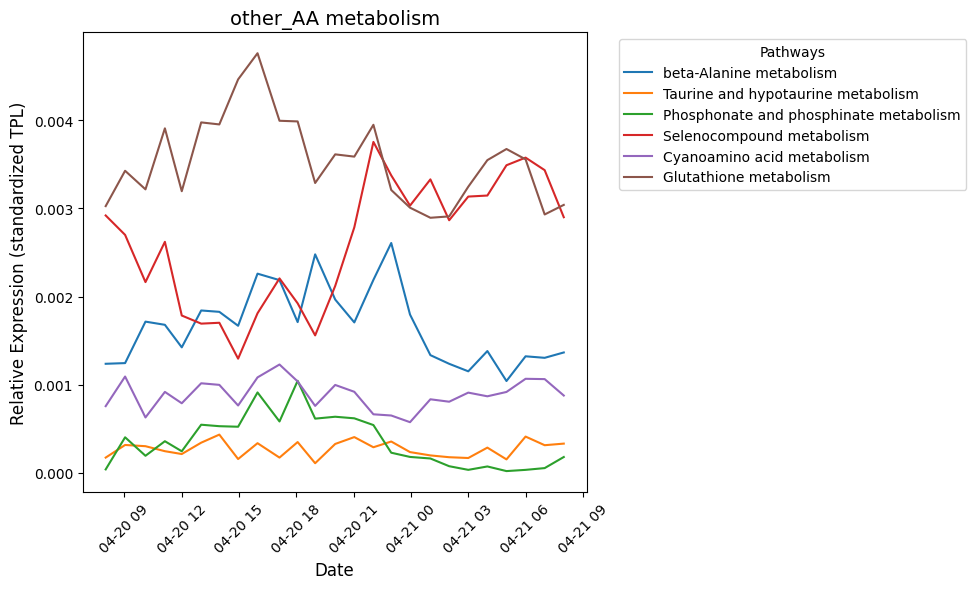

In [21]:
# other_AA metabolism pathways
## Dictionary to store the other_AA pathways
other_AA_metabolism = {
"map00410": "beta-Alanine metabolism", 
"map00430": "Taurine and hypotaurine metabolism", 
"map00440": "Phosphonate and phosphinate metabolism", 
"map00450": "Selenocompound metabolism", 
"map00460": "Cyanoamino acid metabolism", 
"map00470": "D-Amino acid metabolism", 
"map00480": "Glutathione metabolism"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in other_AA_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('other_AA metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()



Pathway map00601 - Glycosphingolipid biosynthesis - lacto and neolacto series not found in the data
Pathway map00540 - Lipopolysaccharide biosynthesis not found in the data
Pathway map00542 - O-Antigen repeat unit biosynthesis not found in the data
Pathway map00541 - O-Antigen nucleotide sugar biosynthesis not found in the data
Pathway map00552 - Teichoic acid biosynthesis not found in the data
Pathway map00571 - Lipoarabinomannan (LAM) biosynthesis not found in the data
Pathway map00572 - Arabinogalactan biosynthesis - Mycobacterium not found in the data
Pathway map00543 - Exopolysaccharide biosynthesis not found in the data


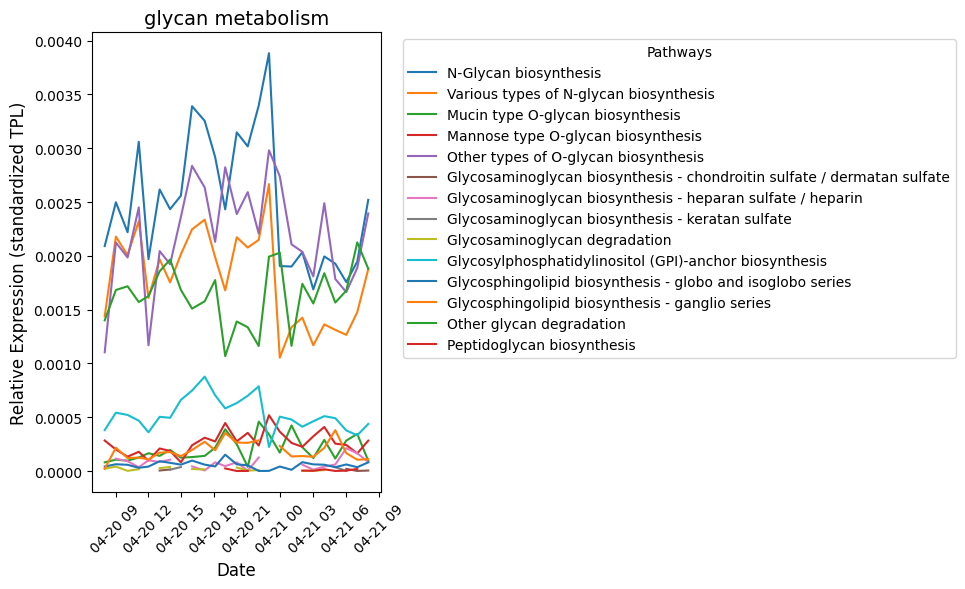

In [22]:
# glycan metabolism pathways
## Dictionary to store the glycan pathways
glycan_metabolism = {
"map00510": "N-Glycan biosynthesis",
"map00513": "Various types of N-glycan biosynthesis",
"map00512": "Mucin type O-glycan biosynthesis",
"map00515": "Mannose type O-glycan biosynthesis",
"map00514": "Other types of O-glycan biosynthesis",
"map00532": "Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate",
"map00534": "Glycosaminoglycan biosynthesis - heparan sulfate / heparin",
"map00533": "Glycosaminoglycan biosynthesis - keratan sulfate",
"map00531": "Glycosaminoglycan degradation",
"map00563": "Glycosylphosphatidylinositol (GPI)-anchor biosynthesis",
"map00601": "Glycosphingolipid biosynthesis - lacto and neolacto series",
"map00603": "Glycosphingolipid biosynthesis - globo and isoglobo series",
"map00604": "Glycosphingolipid biosynthesis - ganglio series",
"map00511": "Other glycan degradation",
"map00540": "Lipopolysaccharide biosynthesis",
"map00542": "O-Antigen repeat unit biosynthesis",
"map00541": "O-Antigen nucleotide sugar biosynthesis",
"map00550": "Peptidoglycan biosynthesis",
"map00552": "Teichoic acid biosynthesis",
"map00571": "Lipoarabinomannan (LAM) biosynthesis",
"map00572": "Arabinogalactan biosynthesis - Mycobacterium",
"map00543": "Exopolysaccharide biosynthesis"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in glycan_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('glycan metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

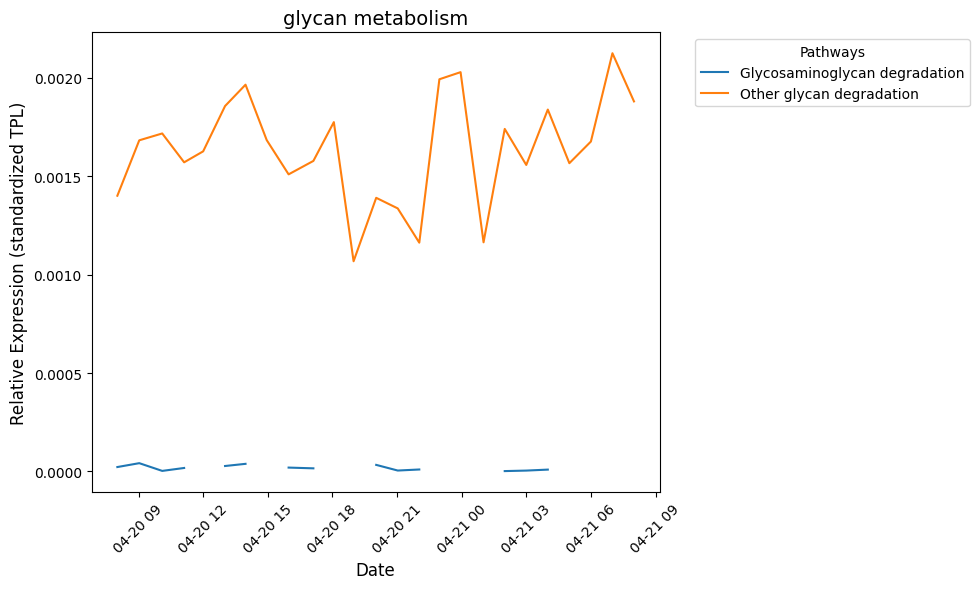

In [23]:
# glycan metabolism pathways
## Dictionary to store the glycan pathways
glycan_metabolism = {
"map00531": "Glycosaminoglycan degradation",
"map00511": "Other glycan degradation",
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in glycan_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('glycan metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

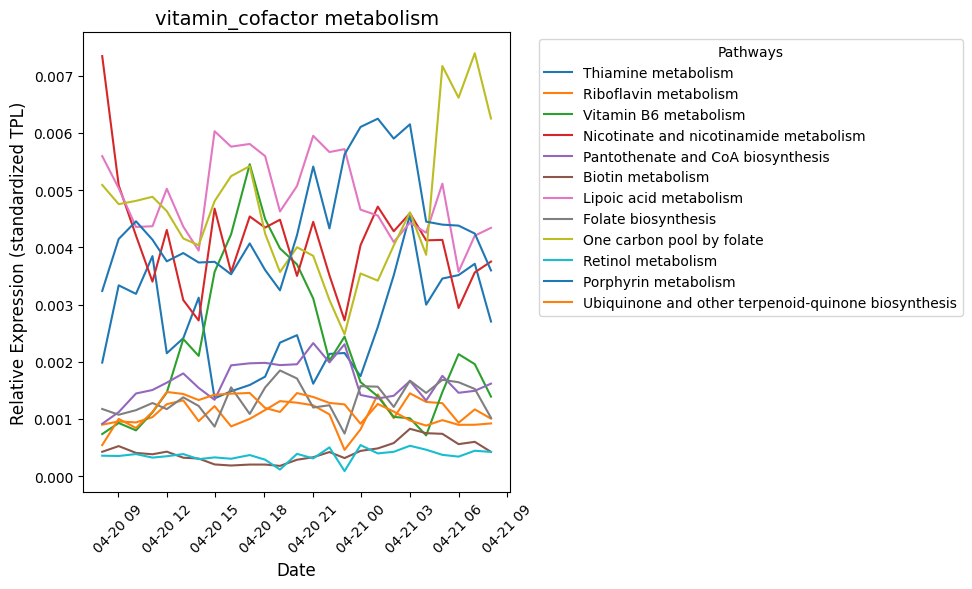

In [24]:
# vitamin_cofactor metabolism pathways
## Dictionary to store the vitamin_cofactor pathways
vitamin_cofactor_metabolism = {
"map00730": "Thiamine metabolism",
"map00740": "Riboflavin metabolism",
"map00750": "Vitamin B6 metabolism",
"map00760": "Nicotinate and nicotinamide metabolism",
"map00770": "Pantothenate and CoA biosynthesis",
"map00780": "Biotin metabolism",
"map00785": "Lipoic acid metabolism",
"map00790": "Folate biosynthesis",
"map00670": "One carbon pool by folate",
"map00830": "Retinol metabolism",
"map00860": "Porphyrin metabolism",
"map00130": "Ubiquinone and other terpenoid-quinone biosynthesis"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in vitamin_cofactor_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('vitamin_cofactor metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map00902 - Monoterpenoid biosynthesis not found in the data
Pathway map00907 - Pinene, camphor and geraniol degradation not found in the data
Pathway map01052 - Type I polyketide structures not found in the data
Pathway map00253 - Tetracycline biosynthesis not found in the data
Pathway map01054 - Nonribosomal peptide structures not found in the data


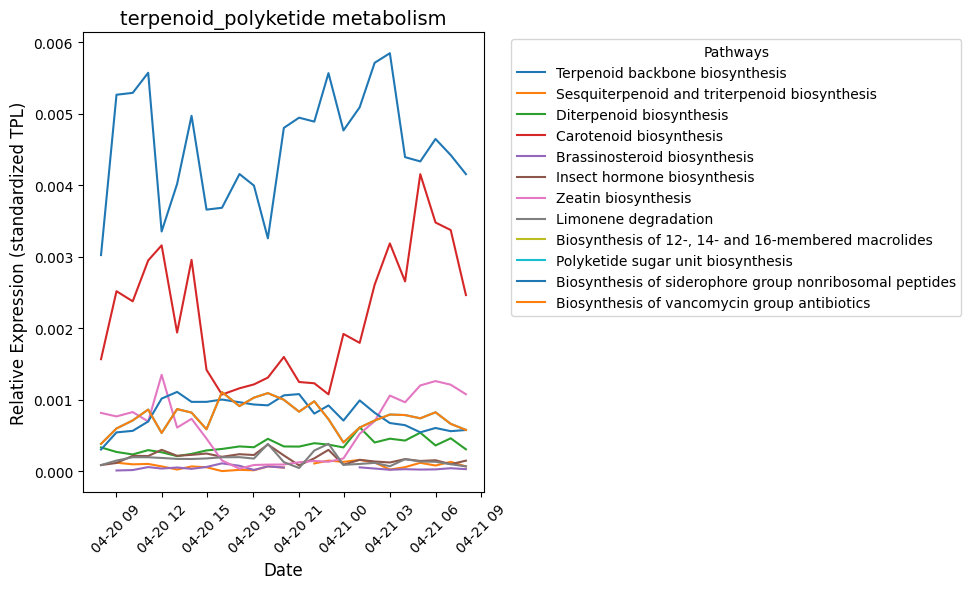

In [25]:
# terpenoid_polyketide metabolism pathways
## Dictionary to store the terpenoid_polyketide pathways
terpenoid_polyketide_metabolism = {
"map00900": "Terpenoid backbone biosynthesis",
"map00902": "Monoterpenoid biosynthesis",
"map00909": "Sesquiterpenoid and triterpenoid biosynthesis",
"map00904": "Diterpenoid biosynthesis",
"map00906": "Carotenoid biosynthesis",
"map00905": "Brassinosteroid biosynthesis",
"map00981": "Insect hormone biosynthesis",
"map00908": "Zeatin biosynthesis",
"map00903": "Limonene degradation",
"map00907": "Pinene, camphor and geraniol degradation",
"map01052": "Type I polyketide structures",
"map00522": "Biosynthesis of 12-, 14- and 16-membered macrolides",
"map00253": "Tetracycline biosynthesis",
"map00523": "Polyketide sugar unit biosynthesis",
"map01054": "Nonribosomal peptide structures",
"map01053": "Biosynthesis of siderophore group nonribosomal peptides",
"map01055": "Biosynthesis of vancomycin group antibiotics"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in terpenoid_polyketide_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('terpenoid_polyketide metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

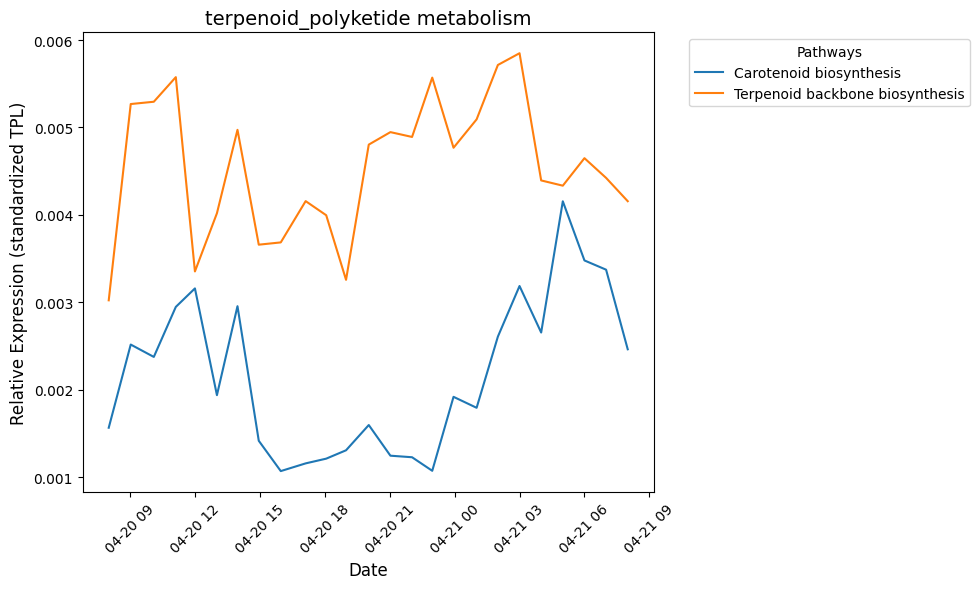

In [26]:
# terpenoid_polyketide metabolism pathways
## Dictionary to store the terpenoid_polyketide pathways
terpenoid_polyketide_metabolism = {
"map00906": "Carotenoid biosynthesis",
"map00900": "Terpenoid backbone biosynthesis",
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in terpenoid_polyketide_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('terpenoid_polyketide metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map00942 - Anthocyanin biosynthesis not found in the data
Pathway map00943 - Isoflavonoid biosynthesis not found in the data
Pathway map00946 - Degradation of flavonoids not found in the data
Pathway map00403 - Indole diterpene alkaloid biosynthesis not found in the data
Pathway map00996 - Biosynthesis of various alkaloids not found in the data
Pathway map00232 - Caffeine metabolism not found in the data
Pathway map00402 - Benzoxazinoid biosynthesis not found in the data
Pathway map00311 - Penicillin and cephalosporin biosynthesis not found in the data
Pathway map00331 - Clavulanic acid biosynthesis not found in the data
Pathway map00404 - Staurosporine biosynthesis not found in the data
Pathway map00998 - Biosynthesis of various antibiotics not found in the data
Pathway map00999 - Biosynthesis of various plant secondary metabolites not found in the data
Pathway map00997 - Biosynthesis of various other secondary metabolites not found in the data


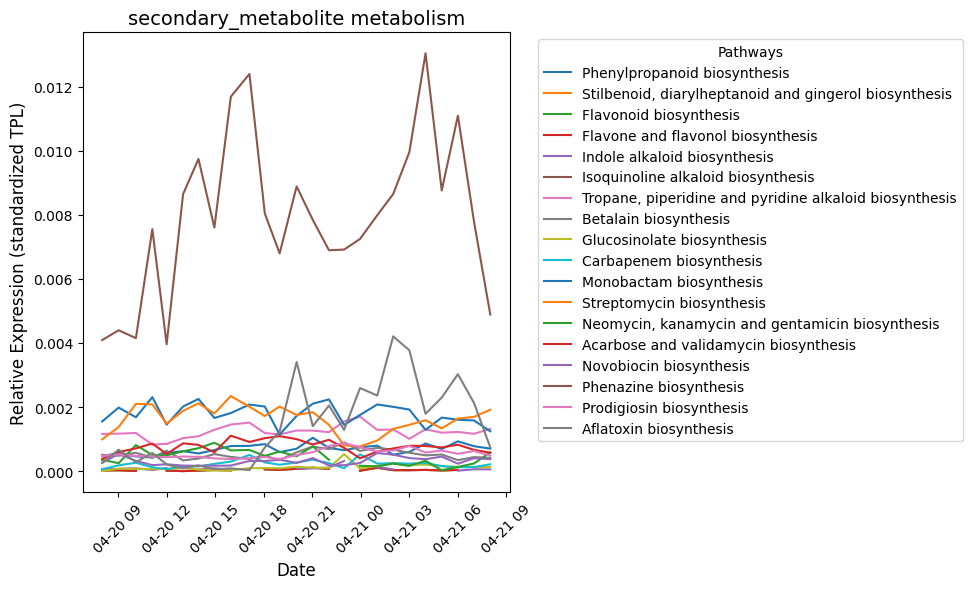

In [27]:
# secondary_metabolite metabolism pathways
## Dictionary to store the secondary_metabolite pathways
secondary_metabolite_metabolism = {
"map00940": "Phenylpropanoid biosynthesis",
"map00945": "Stilbenoid, diarylheptanoid and gingerol biosynthesis",
"map00941": "Flavonoid biosynthesis",
"map00944": "Flavone and flavonol biosynthesis",
"map00942": "Anthocyanin biosynthesis",
"map00943": "Isoflavonoid biosynthesis",
"map00946": "Degradation of flavonoids",
"map00901": "Indole alkaloid biosynthesis",
"map00403": "Indole diterpene alkaloid biosynthesis",
"map00950": "Isoquinoline alkaloid biosynthesis",
"map00960": "Tropane, piperidine and pyridine alkaloid biosynthesis",
"map00996": "Biosynthesis of various alkaloids",
"map00232": "Caffeine metabolism",
"map00965": "Betalain biosynthesis",
"map00966": "Glucosinolate biosynthesis",
"map00402": "Benzoxazinoid biosynthesis",
"map00311": "Penicillin and cephalosporin biosynthesis",
"map00332": "Carbapenem biosynthesis",
"map00261": "Monobactam biosynthesis",
"map00331": "Clavulanic acid biosynthesis",
"map00521": "Streptomycin biosynthesis",
"map00524": "Neomycin, kanamycin and gentamicin biosynthesis",
"map00525": "Acarbose and validamycin biosynthesis",
"map00401": "Novobiocin biosynthesis",
"map00404": "Staurosporine biosynthesis",
"map00405": "Phenazine biosynthesis",
"map00333": "Prodigiosin biosynthesis",
"map00254": "Aflatoxin biosynthesis",
"map00998": "Biosynthesis of various antibiotics",
"map00999": "Biosynthesis of various plant secondary metabolites",
"map00997": "Biosynthesis of various other secondary metabolites"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in secondary_metabolite_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('secondary_metabolite metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

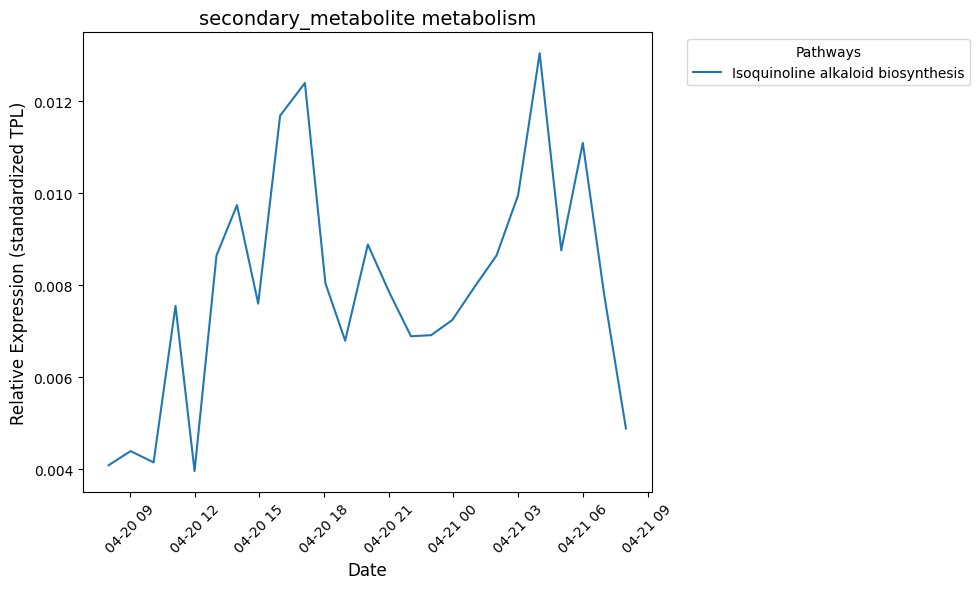

In [28]:
# secondary_metabolite metabolism pathways
## Dictionary to store the secondary_metabolite pathways
secondary_metabolite_metabolism = {
"map00950": "Isoquinoline alkaloid biosynthesis",
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in secondary_metabolite_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('secondary_metabolite metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map00622 - Xylene degradation not found in the data
Pathway map00633 - Nitrotoluene degradation not found in the data
Pathway map00642 - Ethylbenzene degradation not found in the data
Pathway map00791 - Atrazine degradation not found in the data
Pathway map00363 - Bisphenol degradation not found in the data
Pathway map00365 - Furfural degradation not found in the data
Pathway map00984 - Steroid degradation not found in the data


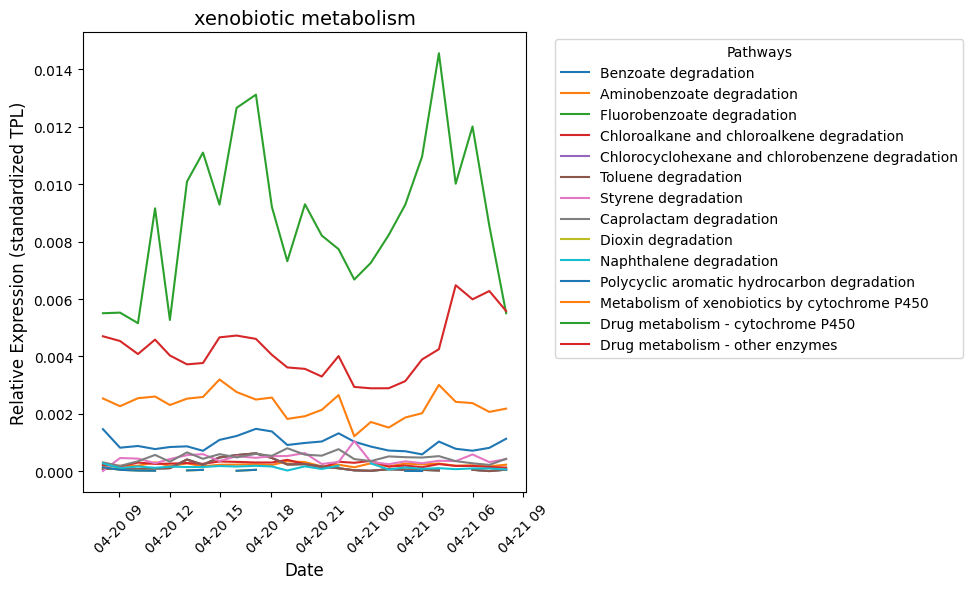

In [29]:
# xenobiotic metabolism pathways
## Dictionary to store the xenobiotic pathways
xenobiotic_metabolism = {
"map00362": "Benzoate degradation", 
"map00627": "Aminobenzoate degradation", 
"map00364": "Fluorobenzoate degradation", 
"map00625": "Chloroalkane and chloroalkene degradation", 
"map00361": "Chlorocyclohexane and chlorobenzene degradation", 
"map00623": "Toluene degradation", 
"map00622": "Xylene degradation", 
"map00633": "Nitrotoluene degradation", 
"map00642": "Ethylbenzene degradation", 
"map00643": "Styrene degradation", 
"map00791": "Atrazine degradation", 
"map00930": "Caprolactam degradation", 
"map00363": "Bisphenol degradation", 
"map00621": "Dioxin degradation", 
"map00626": "Naphthalene degradation", 
"map00624": "Polycyclic aromatic hydrocarbon degradation", 
"map00365": "Furfural degradation", 
"map00984": "Steroid degradation", 
"map00980": "Metabolism of xenobiotics by cytochrome P450", 
"map00982": "Drug metabolism - cytochrome P450", 
"map00983": "Drug metabolism - other enzymes"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in xenobiotic_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('xenobiotic metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

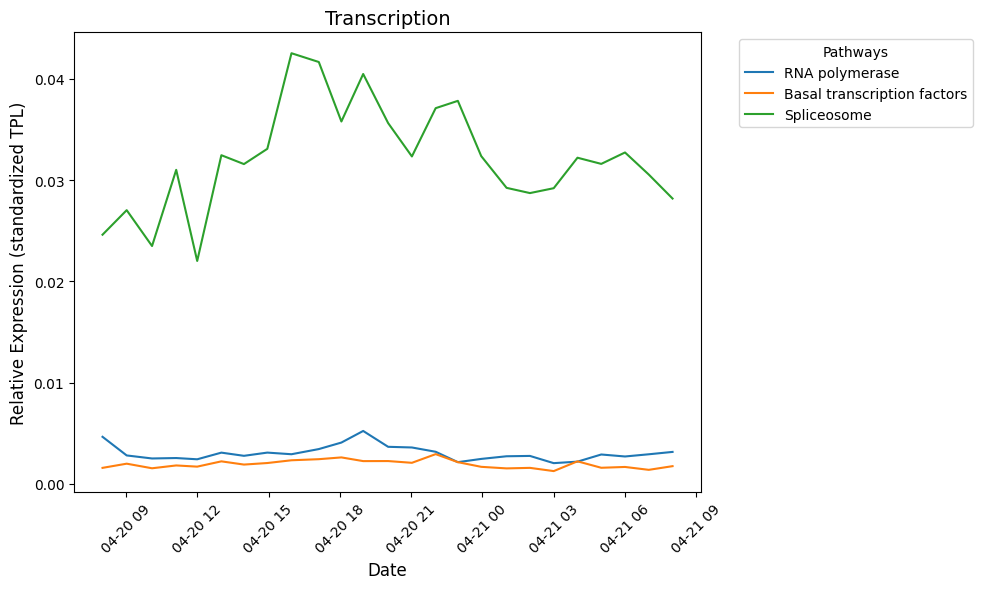

In [30]:
# transcription pathways
## Dictionary to store the xenobiotic pathways
transcription = {
"map03020": 'RNA polymerase',
"map03022": 'Basal transcription factors',
"map03040": 'Spliceosome',
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in transcription.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('Transcription', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

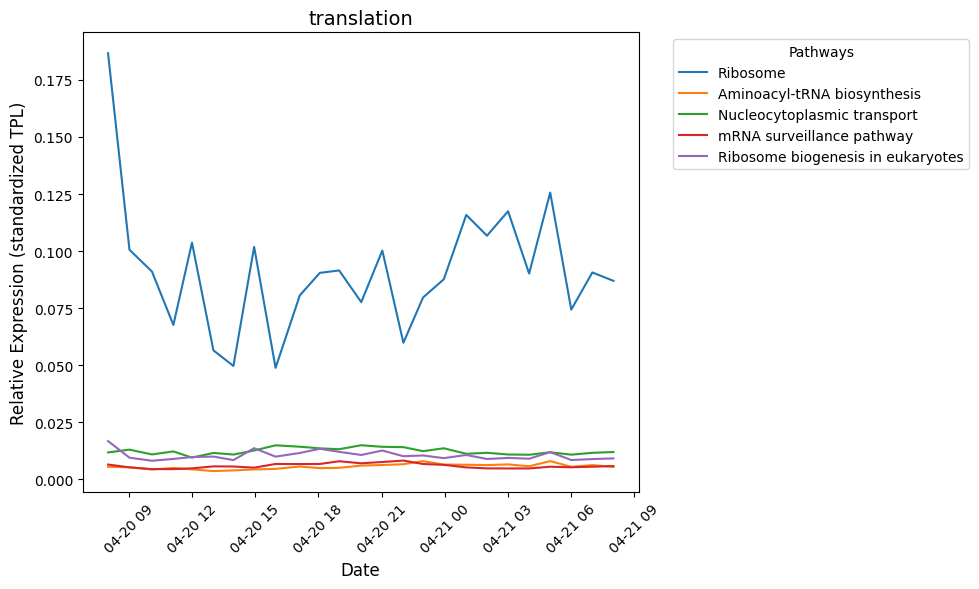

In [31]:
# translation pathways
## Dictionary to store the xenobiotic pathways
translation = {
"map03010": 'Ribosome',
"map00970": "Aminoacyl-tRNA biosynthesis",
"map03013": "Nucleocytoplasmic transport", 
"map03015": "mRNA surveillance pathway", 
"map03008": "Ribosome biogenesis in eukaryotes", 
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in translation.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('translation', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

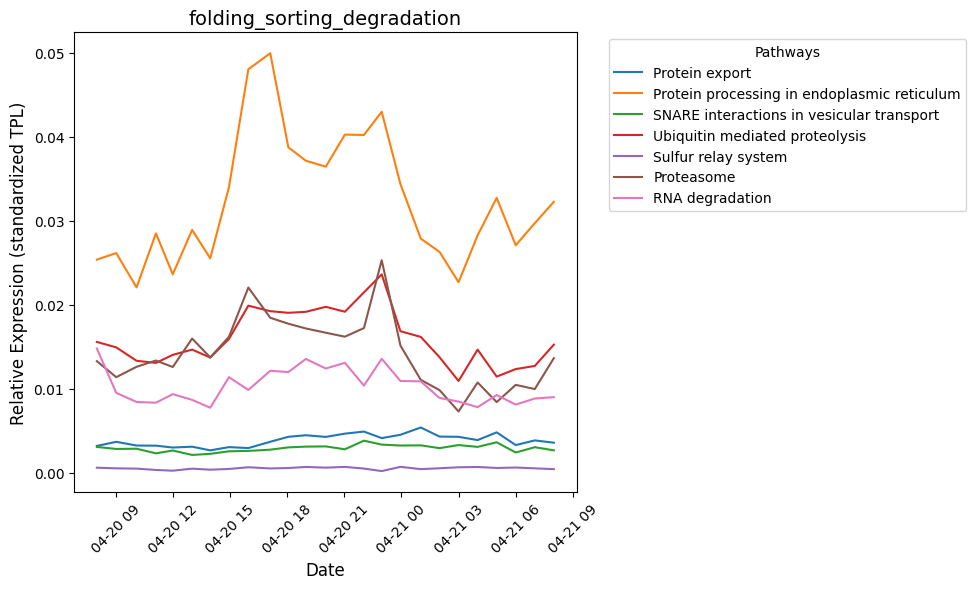

In [32]:
# folding_sorting_degradation pathways
## Dictionary to store the xenobiotic pathways
folding_sorting_degradation = {
"map03060": "Protein export",
"map04141": "Protein processing in endoplasmic reticulum",
"map04130": "SNARE interactions in vesicular transport",
"map04120": "Ubiquitin mediated proteolysis",
"map04122": "Sulfur relay system",
"map03050": "Proteasome",
"map03018": "RNA degradation"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in folding_sorting_degradation.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('folding_sorting_degradation', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

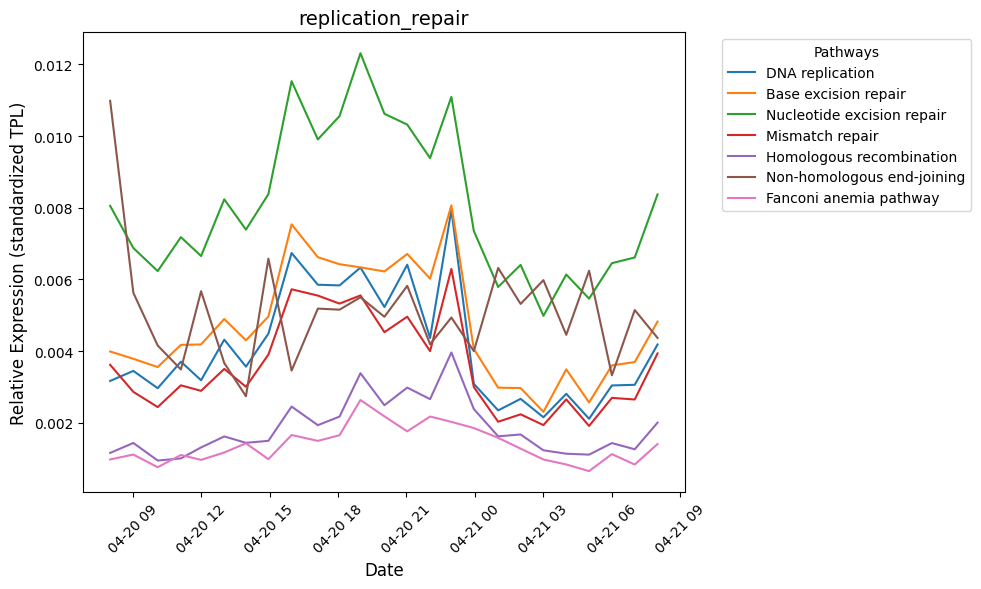

In [33]:
# replication_repair pathways
## Dictionary to store the xenobiotic pathways
replication_repair = {
"map03030": "DNA replication",
"map03410": "Base excision repair",
"map03420": "Nucleotide excision repair",
"map03430": "Mismatch repair",
"map03440": "Homologous recombination",
"map03450": "Non-homologous end-joining",
"map03460": "Fanconi anemia pathway",
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in replication_repair.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('replication_repair', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

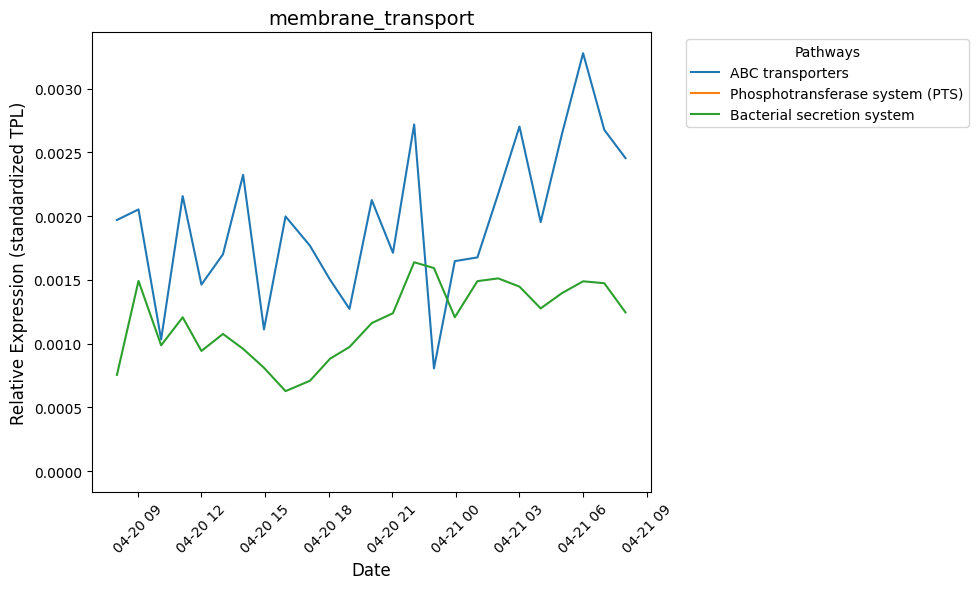

In [34]:
# membrane_transport pathways
## Dictionary to store the xenobiotic pathways
membrane_transport = {
"map02010": "ABC transporters",
"map02060": "Phosphotransferase system (PTS)",
"map03070": "Bacterial secretion system"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in membrane_transport.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('membrane_transport', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

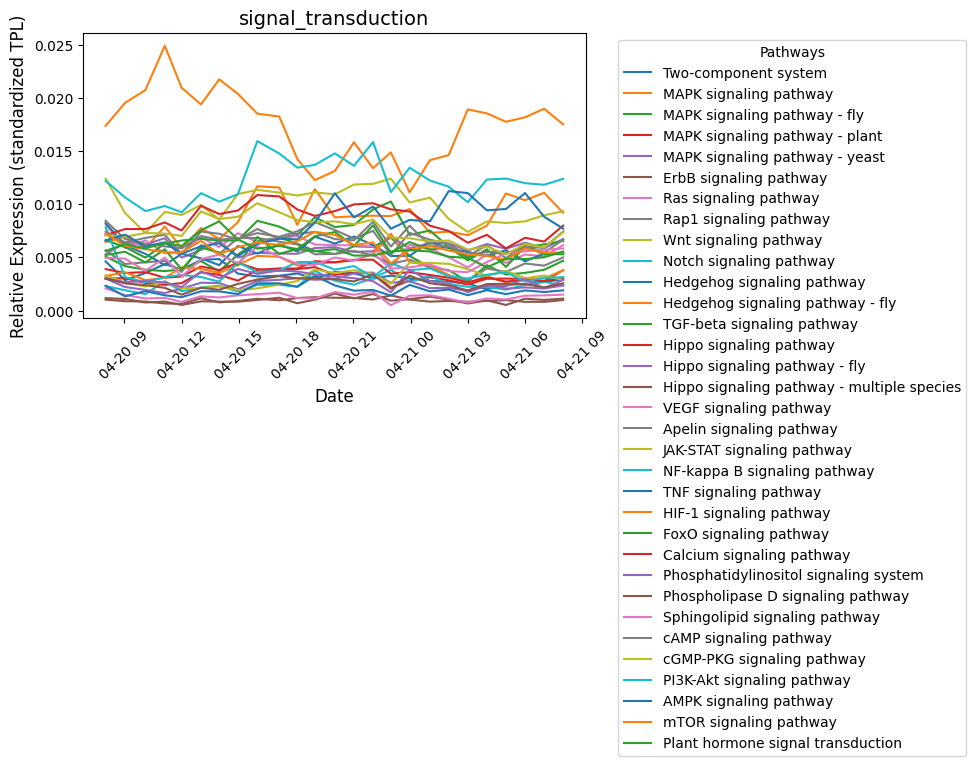

In [35]:
# signal_transduction pathways
## Dictionary to store the xenobiotic pathways
signal_transduction = {
"map02020": "Two-component system", 
"map04010": "MAPK signaling pathway", 
"map04013": "MAPK signaling pathway - fly", 
"map04016": "MAPK signaling pathway - plant", 
"map04011": "MAPK signaling pathway - yeast", 
"map04012": "ErbB signaling pathway", 
"map04014": "Ras signaling pathway", 
"map04015": "Rap1 signaling pathway", 
"map04310": "Wnt signaling pathway", 
"map04330": "Notch signaling pathway", 
"map04340": "Hedgehog signaling pathway", 
"map04341": "Hedgehog signaling pathway - fly", 
"map04350": "TGF-beta signaling pathway", 
"map04390": "Hippo signaling pathway", 
"map04391": "Hippo signaling pathway - fly", 
"map04392": "Hippo signaling pathway - multiple species", 
"map04370": "VEGF signaling pathway", 
"map04371": "Apelin signaling pathway", 
"map04630": "JAK-STAT signaling pathway", 
"map04064": "NF-kappa B signaling pathway", 
"map04668": "TNF signaling pathway", 
"map04066": "HIF-1 signaling pathway", 
"map04068": "FoxO signaling pathway", 
"map04020": "Calcium signaling pathway", 
"map04070": "Phosphatidylinositol signaling system", 
"map04072": "Phospholipase D signaling pathway", 
"map04071": "Sphingolipid signaling pathway", 
"map04024": "cAMP signaling pathway", 
"map04022": "cGMP-PKG signaling pathway", 
"map04151": "PI3K-Akt signaling pathway", 
"map04152": "AMPK signaling pathway", 
"map04150": "mTOR signaling pathway", 
"map04075": "Plant hormone signal transduction"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in signal_transduction.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('signal_transduction', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map04061 - Viral protein interaction with cytokine and cytokine receptor not found in the data


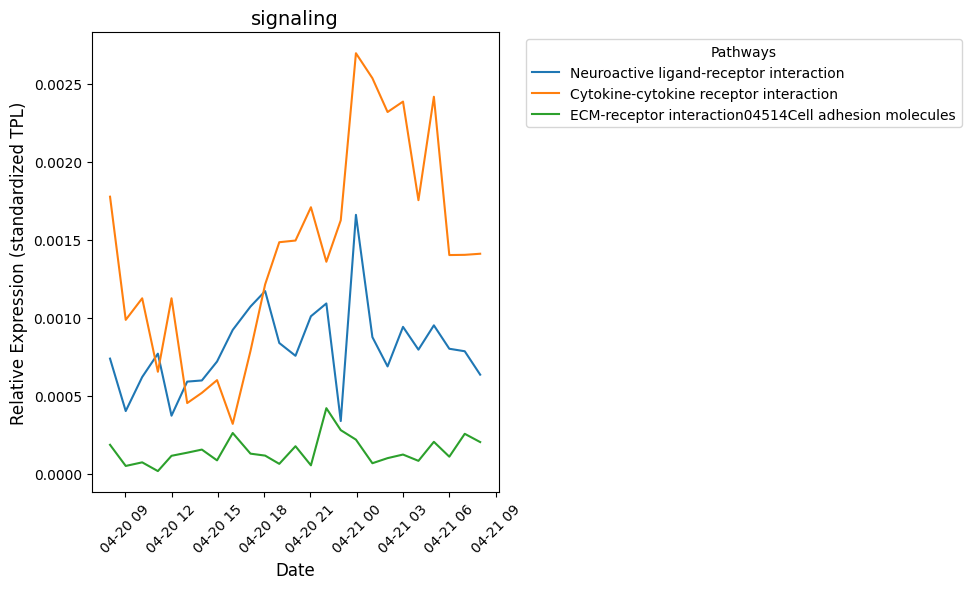

In [36]:
# signaling pathways
## Dictionary to store the xenobiotic pathways
signaling = {
"map04080": "Neuroactive ligand-receptor interaction",
"map04060": "Cytokine-cytokine receptor interaction",
"map04061": "Viral protein interaction with cytokine and cytokine receptor",
"map04512": "ECM-receptor interaction04514Cell adhesion molecules",
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in signaling.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('signaling', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map04148 - Efferocytosis not found in the data


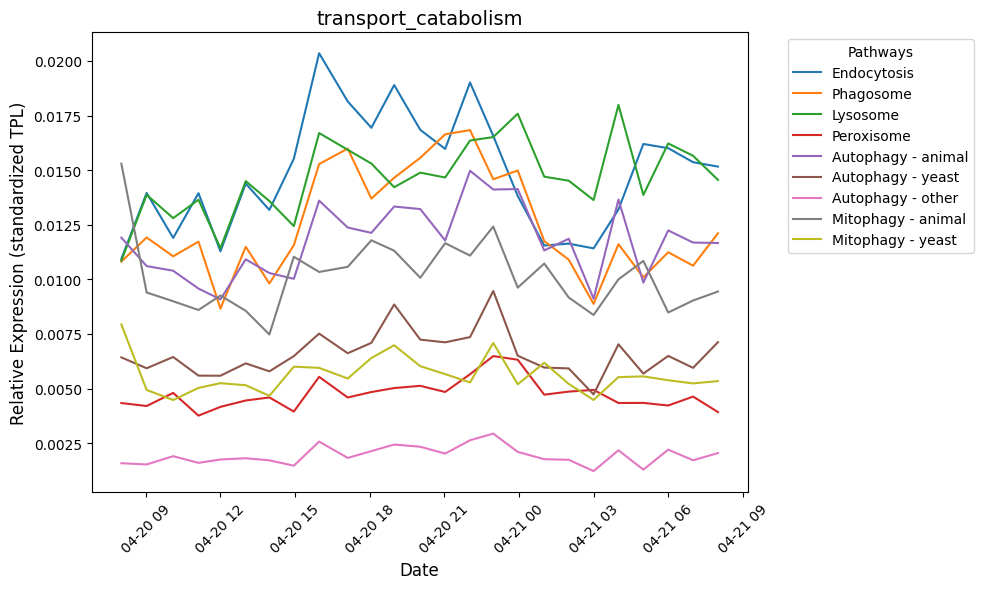

In [37]:
# transport_catabolism pathways
## Dictionary to store the xenobiotic pathways
transport_catabolism = {
"map04144": "Endocytosis", 
"map04145": "Phagosome", 
"map04142": "Lysosome", 
"map04146": "Peroxisome", 
"map04140": "Autophagy - animal", 
"map04138": "Autophagy - yeast", 
"map04136": "Autophagy - other", 
"map04137": "Mitophagy - animal", 
"map04139": "Mitophagy - yeast", 
"map04148": "Efferocytosis"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in transport_catabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('transport_catabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

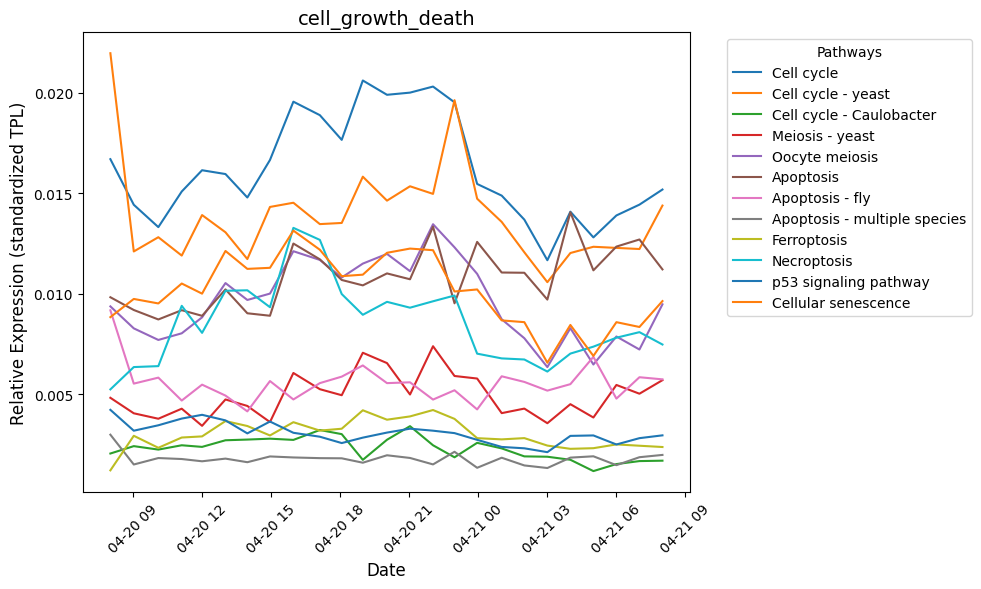

In [38]:
# cell_growth_death pathways
## Dictionary to store the xenobiotic pathways
cell_growth_death = {
"map04110": "Cell cycle",
"map04111": "Cell cycle - yeast",
"map04112": "Cell cycle - Caulobacter",
"map04113": "Meiosis - yeast",
"map04114": "Oocyte meiosis",
"map04210": "Apoptosis",
"map04214": "Apoptosis - fly",
"map04215": "Apoptosis - multiple species",
"map04216": "Ferroptosis",
"map04217": "Necroptosis",
"map04115": "p53 signaling pathway",
"map04218": "Cellular senescence",
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in cell_growth_death.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('cell_growth_death', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

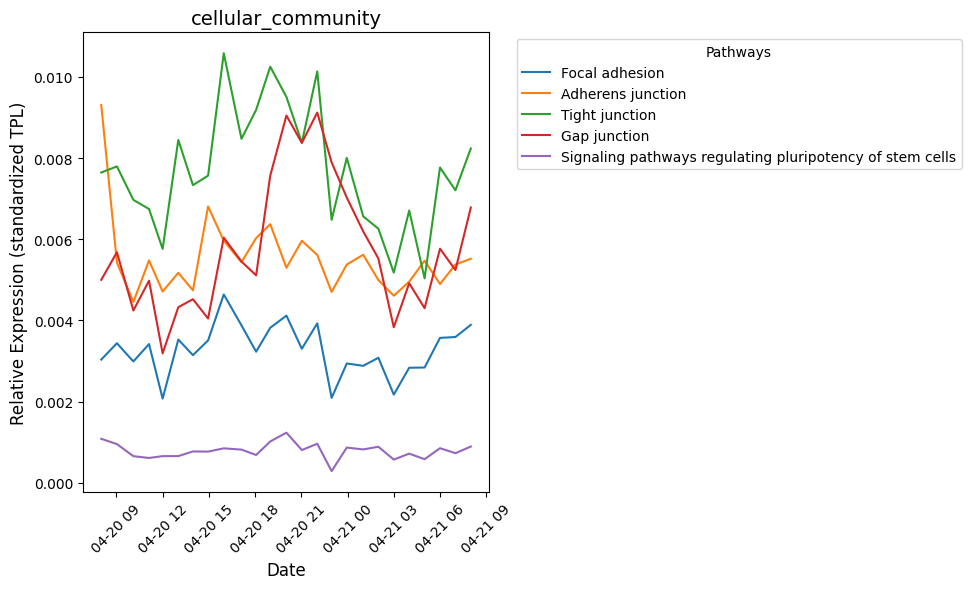

In [39]:
# cellular_community pathways
## Dictionary to store the xenobiotic pathways
cellular_community = {
"map04510": "Focal adhesion", 
"map04520": "Adherens junction", 
"map04530": "Tight junction", 
"map04540": "Gap junction", 
"map04550": "Signaling pathways regulating pluripotency of stem cells", 
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in cellular_community.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('cellular_community', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map02040 - Flagellar assembly not found in the data
Pathway map04814 - Motor proteins not found in the data


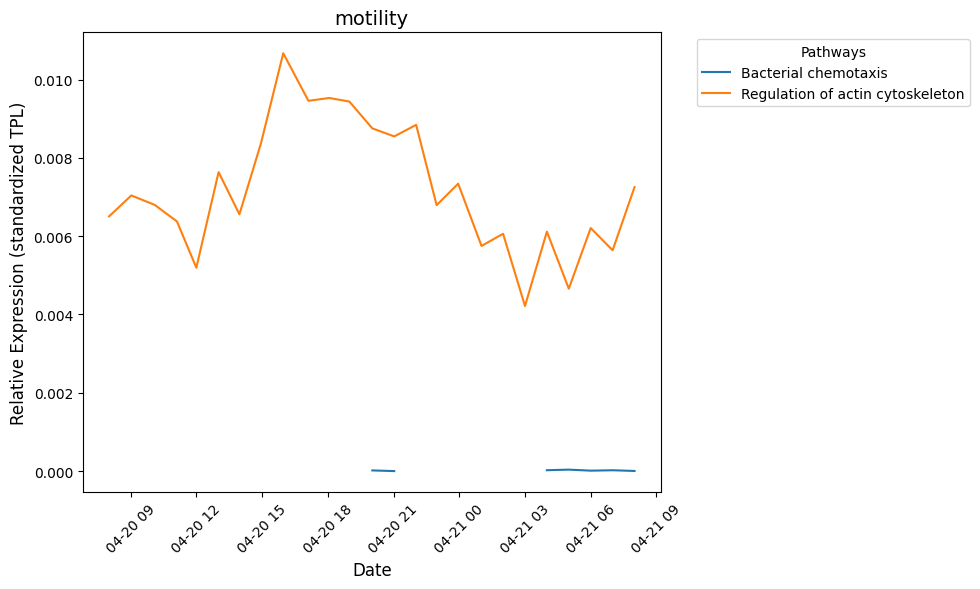

In [40]:
# motility pathways
## Dictionary to store the xenobiotic pathways
motility = {
"map02030": "Bacterial chemotaxis", 
"map02040": "Flagellar assembly", 
"map04814": "Motor proteins", 
"map04810": "Regulation of actin cytoskeleton"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in motility.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('motility', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

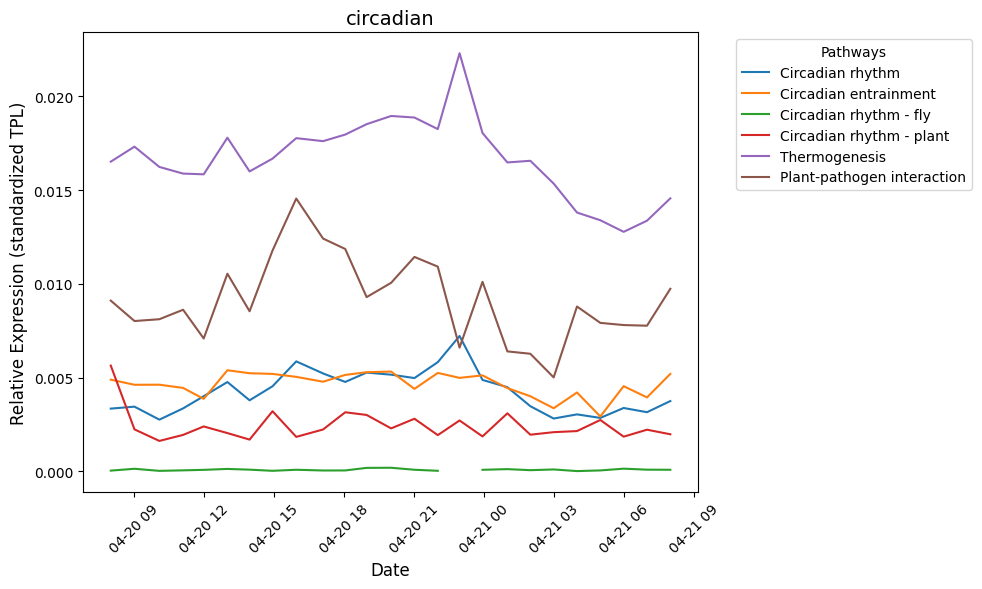

In [41]:
# circadian pathways
## Dictionary to store the xenobiotic pathways
circadian = {
"map04710": "Circadian rhythm",
"map04713": "Circadian entrainment",
"map04711": "Circadian rhythm - fly",
"map04712": "Circadian rhythm - plant",
"map04714": "Thermogenesis",
"map04626": "Plant-pathogen interaction"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in circadian.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('circadian', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## GO Biological processes

Here, we'll try to create a clustered heatmap of higher-level GO terms.
First, we'll extract the GO terms from the data. For these, we'll get their ancestor terms (higher level grouping). 


In [42]:
# Explode the GO terms if they are comma-separated
data['GOs'] = data['GOs'].str.split(',')
data_exploded = data.explode('GOs')

# Extract unique GO terms from the dataset
unique_go_terms = data_exploded['GOs'].unique().tolist()

print(f"Unique GO terms found: {len(unique_go_terms)}")

Unique GO terms found: 15971


In [43]:
data_exploded['GOs'].value_counts().head(10)

GOs
-             853975
GO:0005575    648375
GO:0044464    639075
GO:0005623    639075
GO:0008150    633525
GO:0005622    623825
GO:0044424    621200
GO:0009987    583200
GO:0043226    570050
GO:0003674    568425
Name: count, dtype: int64

In [44]:
# Load the GO slim file (goslim_generic.obo)
go_slim_file = "../data/annotation/functional_eggnog/goslim_plant.obo"
go_dag = GODag(go_slim_file)

# Function to map GO terms to the GO slim category
def map_to_go_slim(go_term, go_dag):
    if go_term in go_dag:
        term = go_dag[go_term]
        return term.name
    return None  # Return None if the term doesn't belong to the GO slim

# Apply the GO slim mapping
data_exploded['GO_slim'] = data_exploded['GOs'].apply(lambda go: map_to_go_slim(go, go_dag))

# Filter out rows where no GO slim mapping was found
data_with_slim = data_exploded.dropna(subset=['GO_slim'])

# Summarize expression by GO slim categories
grouped_expression = data_with_slim.groupby(['GO_slim', 'sample'])['TPL_standardized'].sum().reset_index()

# Replace 0 with NaN in the log-transformed TPL values to interrupt the heatmap
grouped_expression.replace(0, np.nan, inplace=True)

# Merge GO_slim expression with env_data to include the Date column
grouped_expression_with_date = grouped_expression.reset_index().merge(env_data[['sample', 'Date']], on='sample', how='left')

# Convert the Date column to datetime format for proper plotting
grouped_expression_with_date['Date'] = pd.to_datetime(grouped_expression_with_date['Date'])

# Sort the dataframe by Date for better visualization
grouped_expression_with_date = grouped_expression_with_date.sort_values(by='Date')

# Add hours since start for regression analysis downstream
grouped_expression_with_date['hours_since_start'] = (grouped_expression_with_date['Date'] - grouped_expression_with_date['Date'].min()).dt.total_seconds() / 3600

# Pivot the data for heatmap plotting
pivoted_expression = grouped_expression_with_date.pivot(index='GO_slim', columns='Date', values='TPL_standardized')

../data/annotation/functional_eggnog/goslim_plant.obo: fmt(1.2) rel(go/2024-11-03/subsets/goslim_plant.owl) 165 Terms


In [45]:
level = 'GO_slim'

In [46]:
# Check unique GO slim categories
print(f"Unique GO/GO slim categories found: {len(data_exploded[level].unique())}")
print(f"pivoted_expression shape: {pivoted_expression.shape}")

Unique GO/GO slim categories found: 97
pivoted_expression shape: (96, 25)


In [47]:
pivoted_expression.sum(axis=1).sort_values(ascending=False).index[:50]

Index(['cellular_component', 'intracellular anatomical structure',
       'biological_process', 'cytoplasm', 'protein metabolic process',
       'molecular_function', 'cellular process', 'metabolic process',
       'membrane', 'binding', 'cytosol', 'nucleus',
       'cellular component organization', 'biosynthetic process',
       'nucleobase-containing compound metabolic process',
       'catalytic activity', 'transport', 'protein binding',
       'anatomical structure development', 'response to chemical',
       'response to stress', 'protein modification process',
       'multicellular organism development', 'nucleic acid binding',
       'catabolic process', 'RNA binding', 'ribosome', 'translation',
       'nucleoplasm', 'structural molecule activity', 'plasma membrane',
       'plastid', 'cell communication', 'chloroplast', 'cell differentiation',
       'response to abiotic stimulus', 'reproductive process',
       'response to external stimulus', 'nucleolus', 'signal transductio

In [48]:
# Calculate mean expression for each GO term
mean_expression = pivoted_expression.mean(axis=1)

# Z-score normalize the expression data
zscore = lambda x: (x - x.mean()) / x.std()
pivoted_expression_zscore = pivoted_expression.apply(zscore, axis=1)

# Only retain the top 50 GO slim categories with the most expression variance
top_terms = pivoted_expression.var(axis=1).sort_values(ascending=False).index[:50]
pivoted_expression_zscore = pivoted_expression_zscore.loc[top_terms]
mean_expression = mean_expression.loc[top_terms]  # Align mean_expression with selected terms

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_90538/3445677831.py:75: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


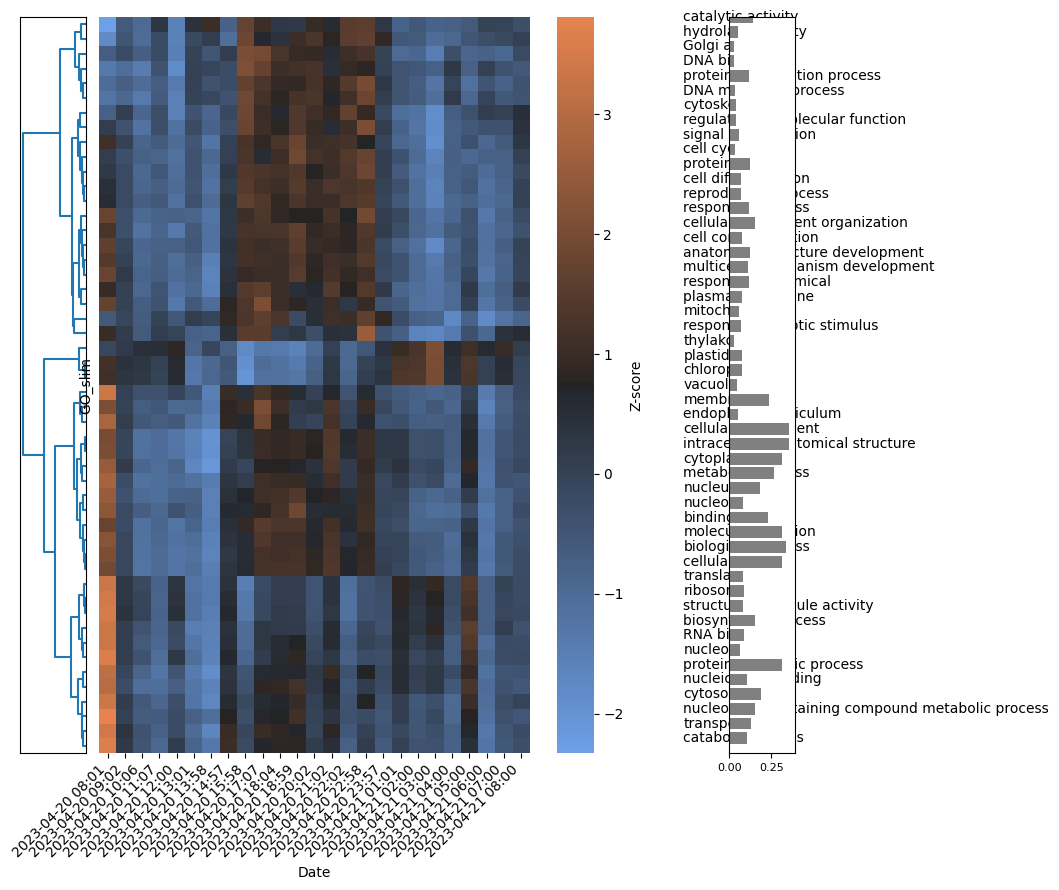

In [49]:
# Perform hierarchical clustering on the Z-score normalized data
row_linkage = linkage(pivoted_expression_zscore.fillna(0), method='ward')

# Get the ordered row indices from the dendrogram
row_order = leaves_list(row_linkage)

# Reorder the rows in the heatmap and mean expression based on the clustering
pivoted_expression_zscore = pivoted_expression_zscore.iloc[row_order]
mean_expression = mean_expression.iloc[row_order]

# Set up the figure with additional space for GO labels
fig = plt.figure(figsize=(10, 12))
dendro_ax = plt.subplot2grid((10, 10), (2, 0), colspan=1, rowspan=8)  # Dendrogram on the left
heatmap_ax = plt.subplot2grid((10, 10), (2, 1), colspan=7, rowspan=8)  # Heatmap
labels_ax = plt.subplot2grid((10, 10), (2, 8), colspan=1, rowspan=8, sharey=heatmap_ax)  # GO labels
side_ax = plt.subplot2grid((10, 10), (2, 9), colspan=1, rowspan=8, sharey=heatmap_ax)  # Sidebar

# Plot the dendrogram
dendrogram(
    row_linkage, 
    ax=dendro_ax, 
    orientation='left', 
    labels=pivoted_expression_zscore.index,
    color_threshold=0  # Optional: Remove colors for clarity
)
dendro_ax.invert_yaxis()  # Align the dendrogram order with the heatmap
dendro_ax.set_xticks([])  # Hide x-ticks
dendro_ax.set_yticks([])  # Hide y-ticks

cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)

# Plot the heatmap
sns.heatmap(
    pivoted_expression_zscore,
    cmap=cmap,
    ax=heatmap_ax,
    cbar_kws={'label': 'Z-score'}
)

# Plot the GO labels
labels_ax.set_xlim(0, 1)  # Arbitrary x-range for text alignment
labels_ax.set_xticks([])  # Remove x-ticks
labels_ax.set_yticks([])  # Remove y-ticks
for i, label in enumerate(pivoted_expression_zscore.index):
    labels_ax.text(0.5, i, label, ha='left', va='center', fontsize=10)
labels_ax.set_axis_off()  # Hide the axis for cleaner appearance

# Plot the sidebar for mean expression
yticks = range(len(mean_expression))  # Align y-ticks with the number of rows

side_ax.barh(
    yticks,
    mean_expression,
    color='gray',
    align='center'
)

# Adjust x-axis for the sidebar
side_ax.set_xlim([0, mean_expression.max() * 1.1])
side_ax.set_xlabel(None)
side_ax.xaxis.set_label_position('top')  # Place label on top
side_ax.tick_params(axis='x', labelsize=8)

# Remove the y-axis for the sidebar to avoid duplicate labels
side_ax.yaxis.set_visible(False)

# Format the x-axis ticks to show the date and hour
heatmap_ax.set_xticklabels(
    pivoted_expression.columns.strftime('%Y-%m-%d %H:%M'),
    rotation=45,
    ha='right'
)

# Final adjustments
plt.tight_layout()
# Save the figure as a SVG file
plt.savefig('../figures/metatranscriptomics/pathway_analysis/GO_slim_heatmap.svg')

plt.show()

### Only select GO terms
As clear from the above, most GO terms are very generic high-level terms. We'll only select the GO terms that are more specific.
I've prepared a .txt file with the GO terms that we'll use.

In [50]:
# Load the full GO DAG
go_dag = GODag("../data/annotation/functional_eggnog/go-basic.obo")

# Load the GO terms of interest
selected_GOs = pd.read_table("../data/annotation/functional_eggnog/interesting_GOs.txt", header=None)
# Transform the GO terms to a list
selected_GOs = selected_GOs[0].tolist()

../data/annotation/functional_eggnog/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms


In [51]:
# Filter dataset by extracted terms
filtered_data = data_exploded[data_exploded['GOs'].isin(selected_GOs)]

grouped_expression = filtered_data.groupby(['GOs', 'sample'])['TPL_standardized'].sum().reset_index()

# Replace 0 with NaN in the log-transformed TPL values to interrupt the heatmap
grouped_expression.replace(0, np.nan, inplace=True)

# Merge GO_slim expression with env_data to include the Date column
grouped_expression_with_date = grouped_expression.reset_index().merge(env_data[['sample', 'Date']], on='sample', how='left')

# Convert the Date column to datetime format for proper plotting
grouped_expression_with_date['Date'] = pd.to_datetime(grouped_expression_with_date['Date'])

# Sort the dataframe by Date for better visualization
grouped_expression_with_date = grouped_expression_with_date.sort_values(by='Date')

# Add hours since start for regression analysis downstream
grouped_expression_with_date['hours_since_start'] = (grouped_expression_with_date['Date'] - grouped_expression_with_date['Date'].min()).dt.total_seconds() / 3600

# Pivot the data for heatmap plotting
pivoted_expression = grouped_expression_with_date.pivot(index='GOs', columns='Date', values='TPL_standardized')

# Create a mapping of GO IDs to names
go_id_to_name = {go_id: go_dag[go_id].name for go_id in pivoted_expression.index if go_id in go_dag}

# Replace the index in pivoted_expression with GO names
pivoted_expression = pivoted_expression.rename(index=go_id_to_name)

In [52]:
go_id_to_name

{'GO:0000096': 'sulfur amino acid metabolic process',
 'GO:0000271': 'polysaccharide biosynthetic process',
 'GO:0000278': 'mitotic cell cycle',
 'GO:0001775': 'cell activation',
 'GO:0002790': 'peptide secretion',
 'GO:0006096': 'glycolytic process',
 'GO:0006276': 'plasmid maintenance',
 'GO:0006457': 'protein folding',
 'GO:0006508': 'proteolysis',
 'GO:0006629': 'lipid metabolic process',
 'GO:0006790': 'sulfur compound metabolic process',
 'GO:0006793': 'phosphorus metabolic process',
 'GO:0006796': 'phosphate-containing compound metabolic process',
 'GO:0006879': 'intracellular iron ion homeostasis',
 'GO:0006903': 'vesicle targeting',
 'GO:0006979': 'response to oxidative stress',
 'GO:0006995': 'cellular response to nitrogen starvation',
 'GO:0007017': 'microtubule-based process',
 'GO:0007049': 'cell cycle',
 'GO:0007623': 'circadian rhythm',
 'GO:0008219': 'cell death',
 'GO:0008610': 'lipid biosynthetic process',
 'GO:0008652': 'amino acid biosynthetic process',
 'GO:0009101

In [53]:
# Check the name of the most abundant GO terms
most_abundant_GOs = data_exploded['GOs'].value_counts().head(300)

# Add the names of the GO terms to the most_abundant_GOs
most_abundant_GOs = {go_id: go_dag[go_id].name for go_id in most_abundant_GOs.index if go_id in go_dag}

most_abundant_GOs

{'GO:0005575': 'cellular_component',
 'GO:0008150': 'biological_process',
 'GO:0005622': 'intracellular anatomical structure',
 'GO:0009987': 'cellular process',
 'GO:0043226': 'organelle',
 'GO:0003674': 'molecular_function',
 'GO:0043229': 'intracellular organelle',
 'GO:0005737': 'cytoplasm',
 'GO:0043227': 'membrane-bounded organelle',
 'GO:0043231': 'intracellular membrane-bounded organelle',
 'GO:0008152': 'metabolic process',
 'GO:0044238': 'primary metabolic process',
 'GO:0005488': 'binding',
 'GO:0065007': 'biological regulation',
 'GO:0050789': 'regulation of biological process',
 'GO:0043170': 'macromolecule metabolic process',
 'GO:0050896': 'response to stimulus',
 'GO:0003824': 'catalytic activity',
 'GO:0050794': 'regulation of cellular process',
 'GO:0005634': 'nucleus',
 'GO:0071840': 'cellular component organization or biogenesis',
 'GO:0032991': 'protein-containing complex',
 'GO:0016043': 'cellular component organization',
 'GO:0005515': 'protein binding',
 'GO:003

In [54]:
# Retrieve and print aspect for each GO term
go_aspects = {}
for go_term in selected_GOs:
    go_obj = go_dag.get(go_term)
    if go_obj:
        go_aspects[go_term] = go_obj.namespace

print(go_aspects)

# Are they all biological processes?
all(go_aspects[go] == 'biological_process' for go in go_aspects)

# Which GO terms are not biological processes?
{go: aspect for go, aspect in go_aspects.items() if aspect != 'biological_process'}

{'GO:0015979': 'biological_process', 'GO:0009765': 'biological_process', 'GO:0019684': 'biological_process', 'GO:0019253': 'biological_process', 'GO:0009416': 'biological_process', 'GO:0008610': 'biological_process', 'GO:0031408': 'biological_process', 'GO:0015698': 'biological_process', 'GO:0008652': 'biological_process', 'GO:0006796': 'biological_process', 'GO:0043562': 'biological_process', 'GO:0006979': 'biological_process', 'GO:0046686': 'biological_process', 'GO:0043650': 'biological_process', 'GO:0043466': 'biological_process', 'GO:0009698': 'biological_process', 'GO:0044550': 'biological_process', 'GO:0016114': 'biological_process', 'GO:0010258': 'biological_process', 'GO:0006096': 'biological_process', 'GO:0009101': 'biological_process', 'GO:0006790': 'biological_process', 'GO:0019344': 'biological_process', 'GO:0000096': 'biological_process', 'GO:0006879': 'biological_process', 'GO:0034755': 'biological_process', 'GO:0051301': 'biological_process', 'GO:0007049': 'biological_p

{}

In [55]:
level = 'GOs'

In [56]:
# Check unique GO slim categories
print(f"Unique GO/GO slim categories found: {len(data_exploded[level].unique())}")
print(f"pivoted_expression shape: {pivoted_expression.shape}")

Unique GO/GO slim categories found: 15971
pivoted_expression shape: (77, 25)


In [57]:
pivoted_expression.sum(axis=1).sort_values(ascending=False).index[:50]

Index(['signaling', 'phosphorus metabolic process',
       'phosphate-containing compound metabolic process',
       'regulation of signaling', 'vesicle-mediated transport', 'proteolysis',
       'sexual reproduction', 'cell cycle',
       'carbohydrate derivative metabolic process', 'mitotic cell cycle',
       'regulation of reproductive process', 'microtubule-based process',
       'transmembrane transport', 'response to cadmium ion', 'cell death',
       'response to oxidative stress', 'growth', 'protein folding',
       'regulation of growth', 'lipid metabolic process',
       'response to light stimulus', 'cell activation', 'cell division',
       'cell motility', 'sulfur compound metabolic process',
       'lipid biosynthetic process', 'regulation of locomotion', 'cell growth',
       'photosynthesis', 'amino acid biosynthetic process',
       'peptide secretion', 'photosynthesis, light reaction',
       'glycolytic process', 'circadian rhythm', 'regulation of viral process',
  

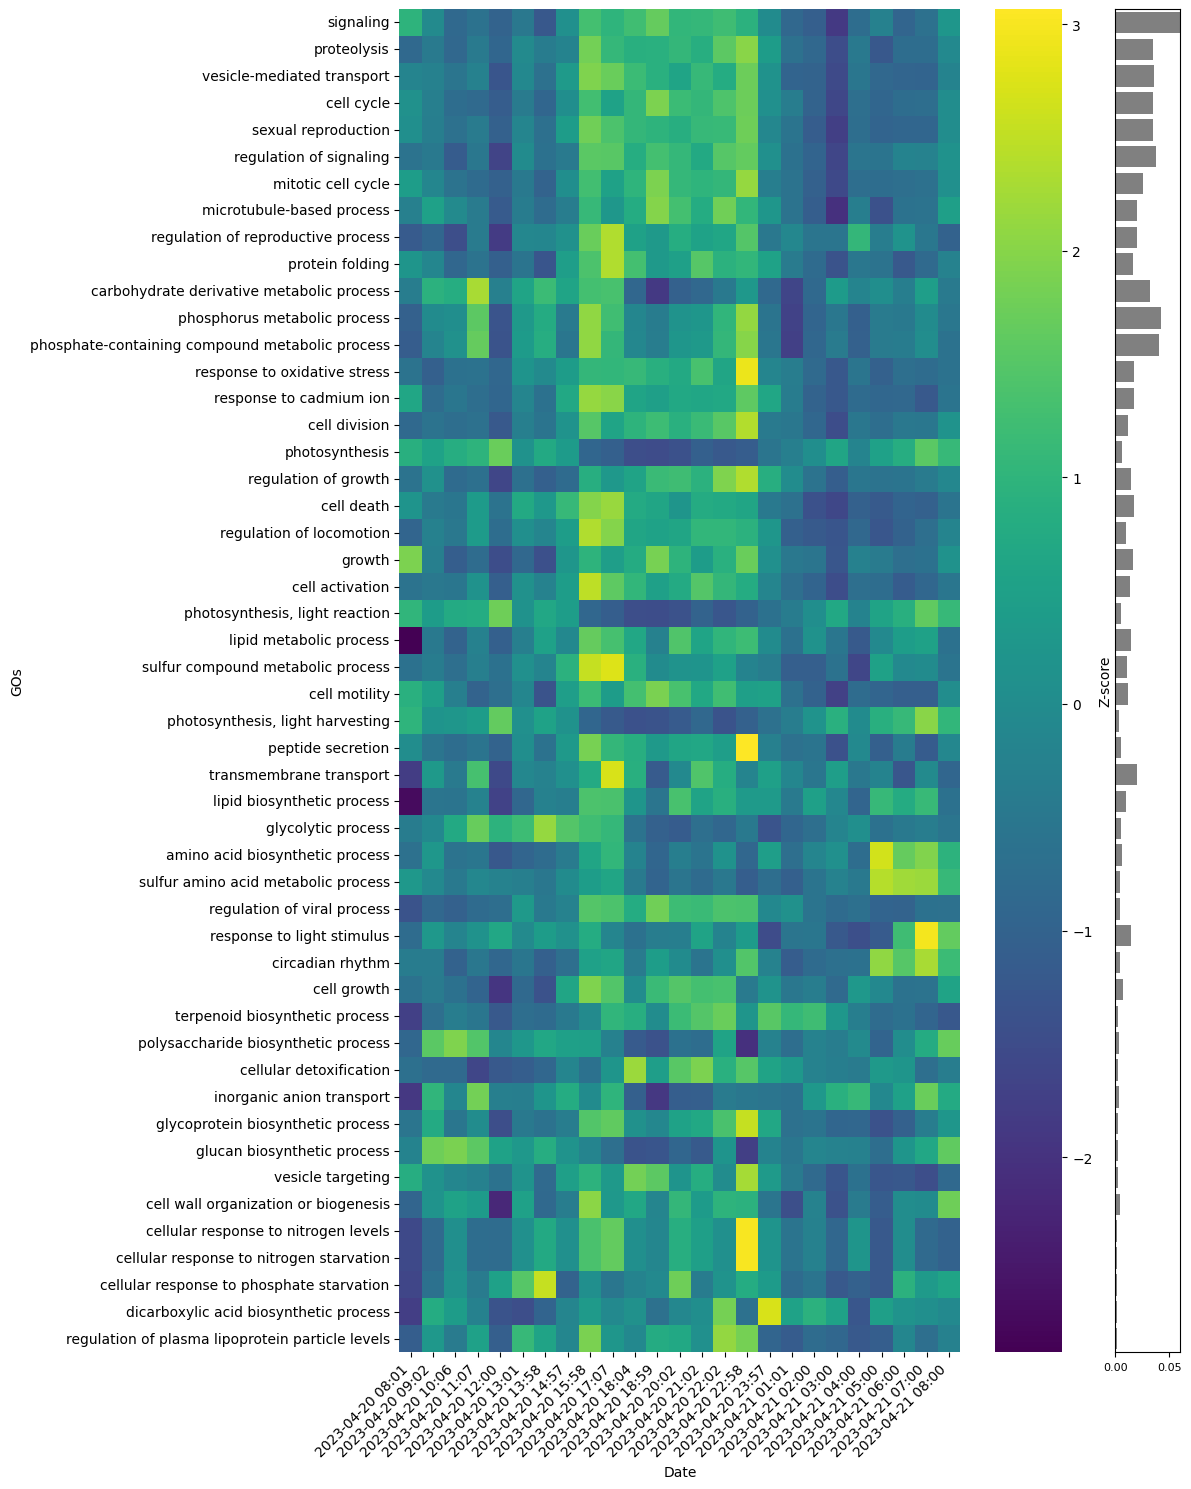

In [58]:
# Calculate mean expression for each GO term
mean_expression = pivoted_expression.mean(axis=1)

# Z-score normalize the expression data
zscore = lambda x: (x - x.mean()) / x.std()
pivoted_expression_zscore = pivoted_expression.apply(zscore, axis=1)

# Only retain the top 50 GO slim categories with the most expression variance
top_terms = pivoted_expression.var(axis=1).sort_values(ascending=False).index[:50]
pivoted_expression_zscore = pivoted_expression_zscore.loc[top_terms]
mean_expression = mean_expression.loc[top_terms]  # Align mean_expression with selected terms

# Set up the figure
fig = plt.figure(figsize=(12, 15))
heatmap_ax = plt.subplot2grid((1, 10), (0, 0), colspan=9)
side_ax = plt.subplot2grid((1, 10), (0, 9), colspan=1, sharey=heatmap_ax)

# Plot the heatmap
sns.heatmap(
    pivoted_expression_zscore,
    cmap='viridis',
    ax=heatmap_ax,
    cbar_kws={'label': 'Z-score'}
)

# Get heatmap y-ticks for alignment
yticks = heatmap_ax.get_yticks()

# Plot the side bar for mean expression
side_ax.barh(
    yticks,
    mean_expression,
    color='gray',
    align='center'
)

# Adjust x-axis for the side bar
side_ax.set_xlim([0, mean_expression.max()])
side_ax.set_xlabel(None)
side_ax.xaxis.set_label_position('top')  # Place label on top
side_ax.tick_params(axis='x', labelsize=8)

# Remove the y-axis for the side bar to avoid duplicate labels
side_ax.yaxis.set_visible(False)

# Format the x-axis ticks to show the date and hour
heatmap_ax.set_xticklabels(
    pivoted_expression.columns.strftime('%Y-%m-%d %H:%M'),
    rotation=45,
    ha='right'
)

# Set y-axis labels on the heatmap to match the GO terms
heatmap_ax.set_yticklabels(pivoted_expression_zscore.index, rotation=0)

# Final adjustments
plt.tight_layout()
plt.show()

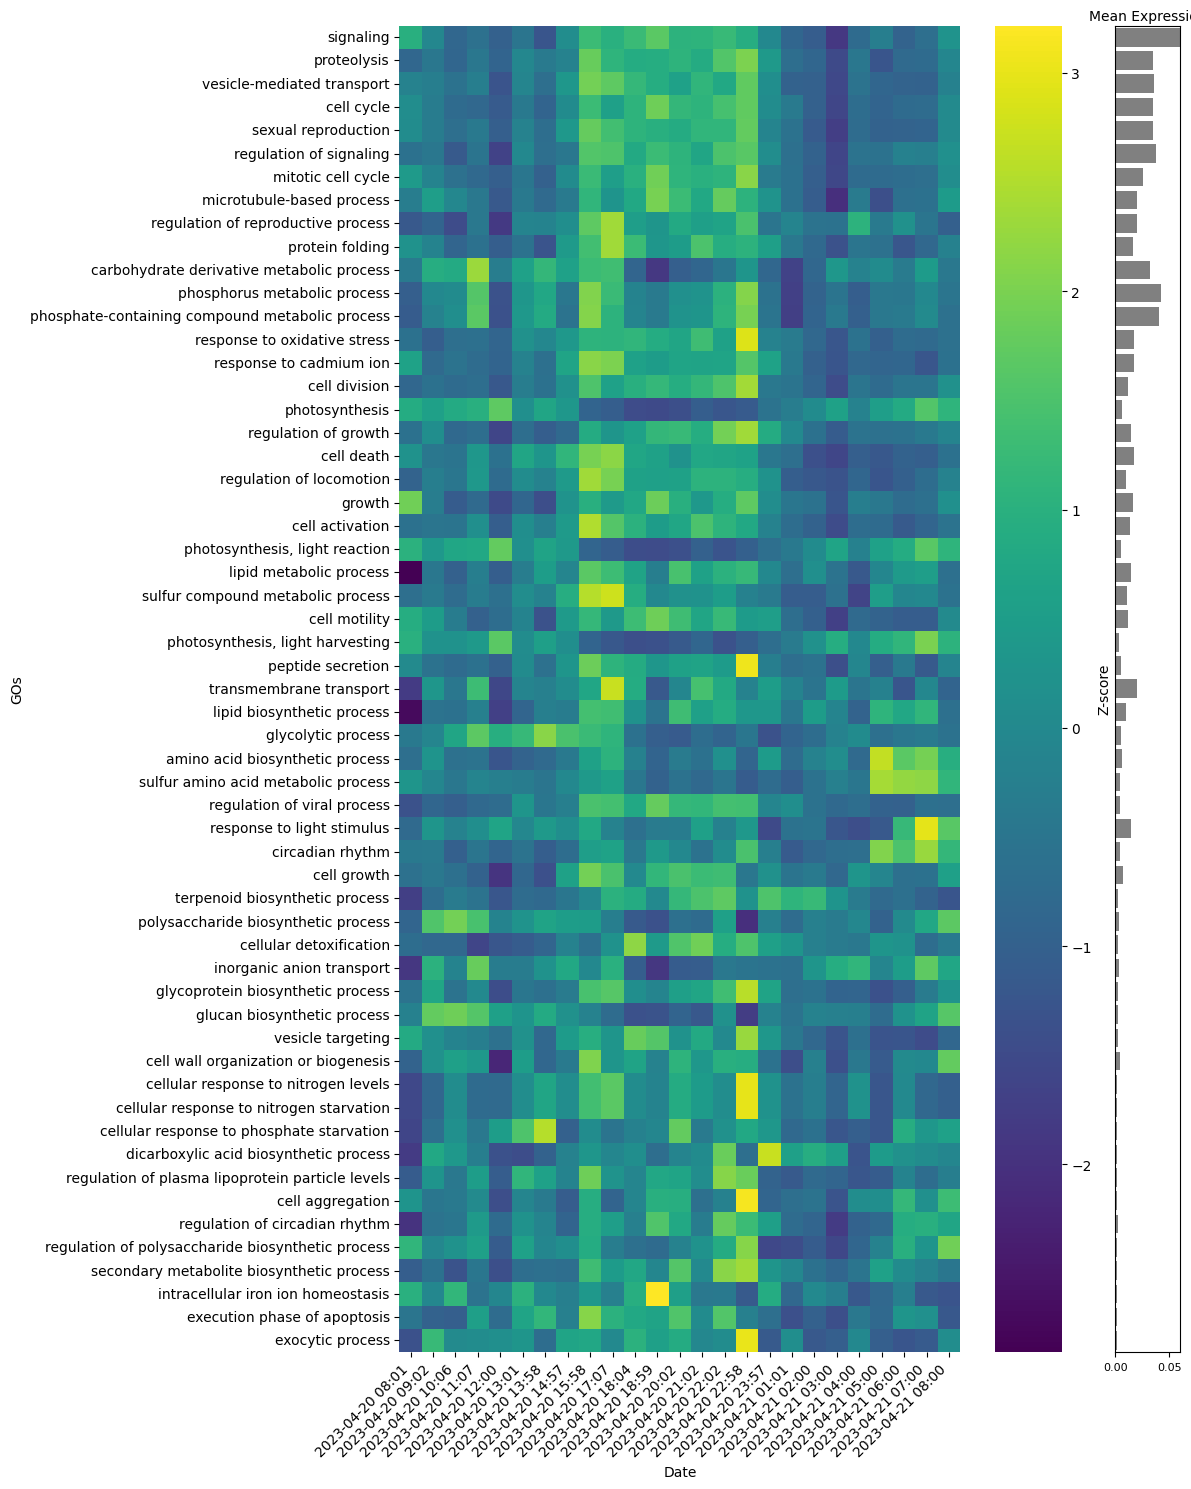

In [59]:
# Calculate mean expression for each GO term
mean_expression = pivoted_expression.mean(axis=1)

# Z-score normalize the expression data
zscore = lambda x: (x - x.mean()) / x.std()
pivoted_expression_zscore = pivoted_expression.apply(zscore, axis=1)

# Only retain the top 100 GO slim categories with the most expression variance
top_terms = pivoted_expression.var(axis=1).sort_values(ascending=False).index[:100]
pivoted_expression_zscore = pivoted_expression_zscore.loc[top_terms]
mean_expression = mean_expression.loc[top_terms]  # Align mean_expression with selected terms

# Remove GO terms with low mean expression
pivoted_expression_zscore = pivoted_expression_zscore.loc[mean_expression > 0.001]
mean_expression = mean_expression.loc[mean_expression > 0.001]

# Set up the figure
fig = plt.figure(figsize=(12, 15))
heatmap_ax = plt.subplot2grid((1, 10), (0, 0), colspan=9)
side_ax = plt.subplot2grid((1, 10), (0, 9), colspan=1, sharey=heatmap_ax)

# Plot the heatmap
sns.heatmap(
    pivoted_expression_zscore,
    cmap='viridis',
    ax=heatmap_ax,
    cbar_kws={'label': 'Z-score'}
)

# Get heatmap y-ticks for alignment
yticks = heatmap_ax.get_yticks()

# Plot the side bar for mean expression
side_ax.barh(
    yticks,
    mean_expression,
    color='gray',
    align='center'
)

# Adjust x-axis for the side bar
side_ax.set_xlim([0, mean_expression.max()])
side_ax.set_xlabel('Mean Expression', fontsize=10)
side_ax.xaxis.set_label_position('top')  # Place label on top
side_ax.tick_params(axis='x', labelsize=8)

# Remove the y-axis for the side bar to avoid duplicate labels
side_ax.yaxis.set_visible(False)

# Format the x-axis ticks to show the date and hour
heatmap_ax.set_xticklabels(
    pivoted_expression.columns.strftime('%Y-%m-%d %H:%M'),
    rotation=45,
    ha='right'
)

# Set y-axis labels on the heatmap to match the GO terms
heatmap_ax.set_yticklabels(pivoted_expression_zscore.index, rotation=0)

# Final adjustments
plt.tight_layout()
plt.show()

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_90538/451530789.py:75: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


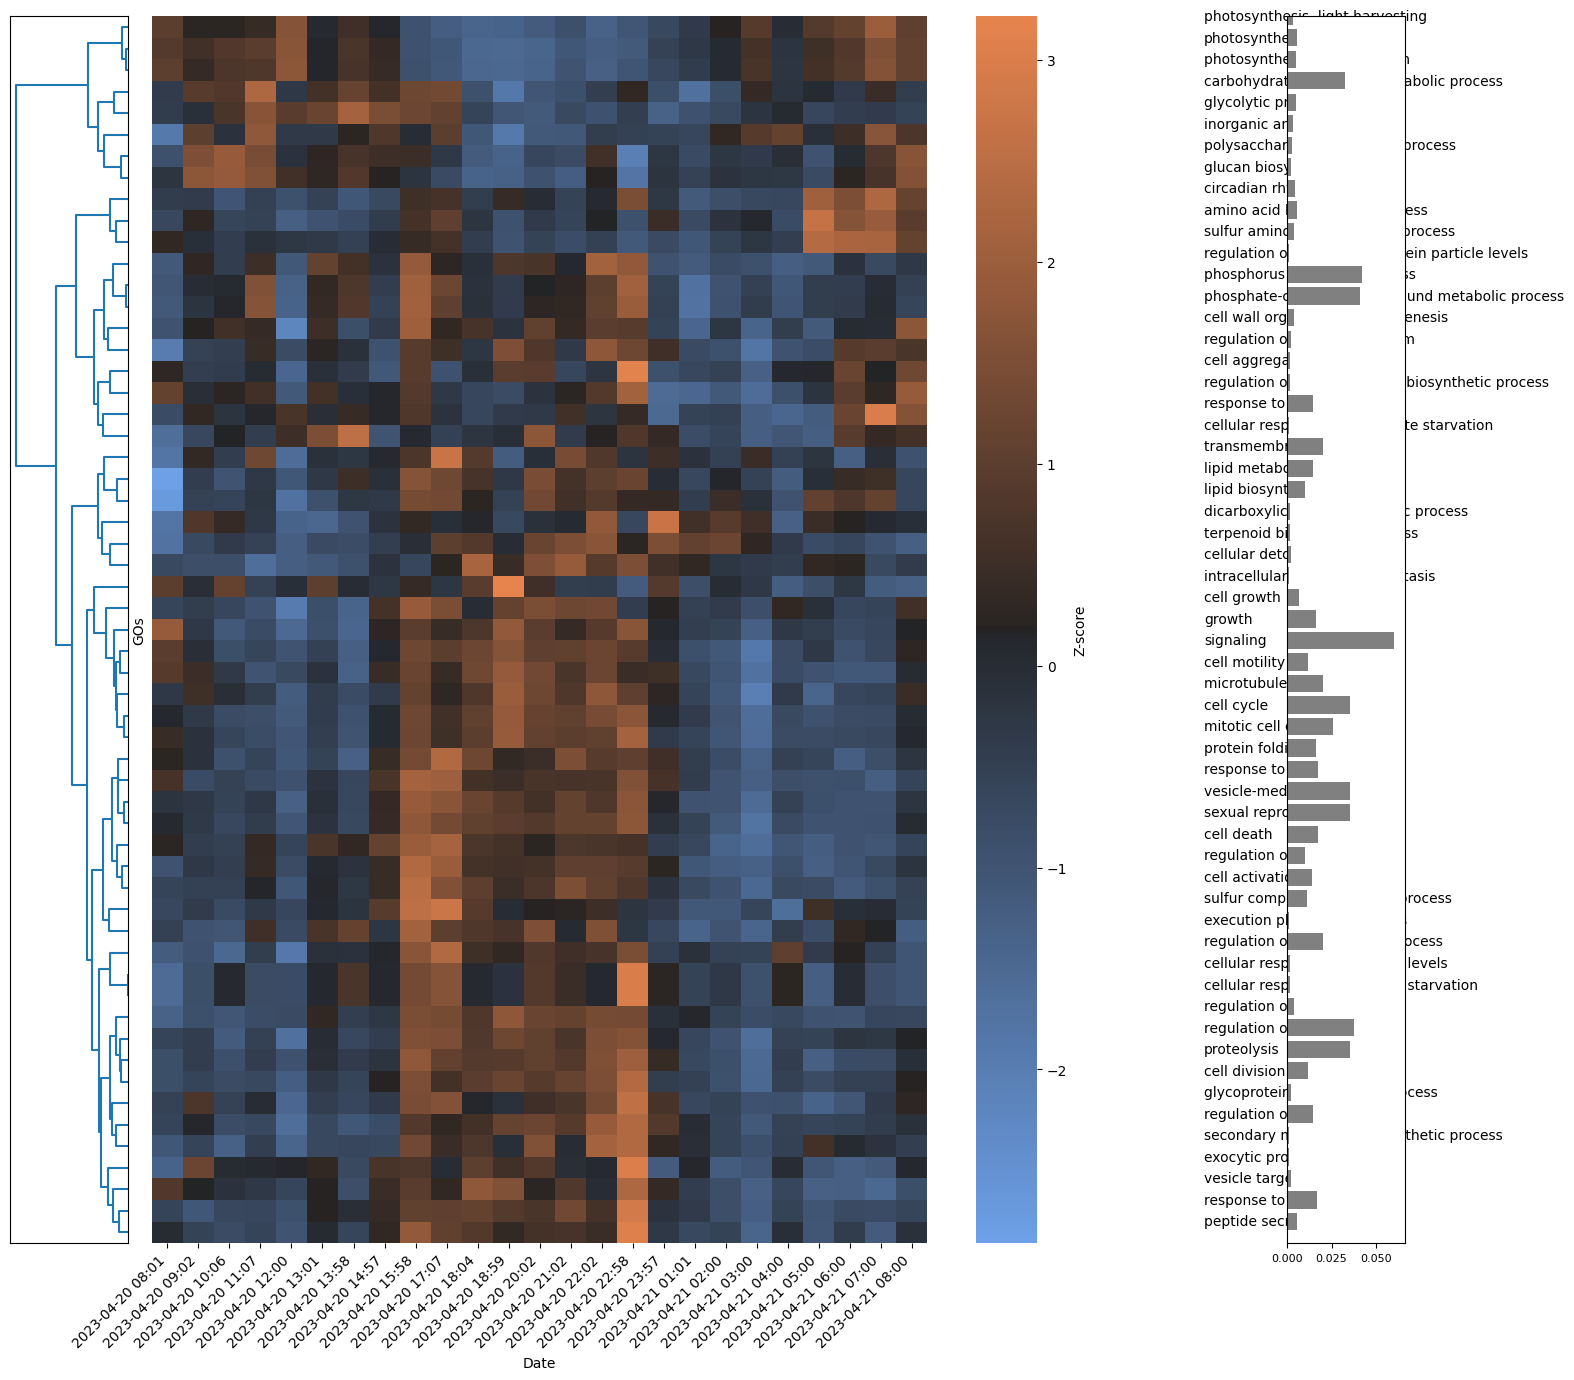

In [60]:
# Perform hierarchical clustering on the Z-score normalized data
row_linkage = linkage(pivoted_expression_zscore.fillna(0), method='ward')

# Get the ordered row indices from the dendrogram
row_order = leaves_list(row_linkage)

# Reorder the rows in the heatmap and mean expression based on the clustering
pivoted_expression_zscore = pivoted_expression_zscore.iloc[row_order]
mean_expression = mean_expression.iloc[row_order]

# Set up the figure with additional space for GO labels
fig = plt.figure(figsize=(18, 20))
dendro_ax = plt.subplot2grid((10, 10), (2, 0), colspan=1, rowspan=8)  # Dendrogram on the left
heatmap_ax = plt.subplot2grid((10, 10), (2, 1), colspan=7, rowspan=8)  # Heatmap
labels_ax = plt.subplot2grid((10, 10), (2, 8), colspan=1, rowspan=8, sharey=heatmap_ax)  # GO labels
side_ax = plt.subplot2grid((10, 10), (2, 9), colspan=1, rowspan=8, sharey=heatmap_ax)  # Sidebar

# Plot the dendrogram
dendrogram(
    row_linkage, 
    ax=dendro_ax, 
    orientation='left', 
    labels=pivoted_expression_zscore.index,
    color_threshold=0  # Optional: Remove colors for clarity
)
dendro_ax.invert_yaxis()  # Align the dendrogram order with the heatmap
dendro_ax.set_xticks([])  # Hide x-ticks
dendro_ax.set_yticks([])  # Hide y-ticks

cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)

# Plot the heatmap
sns.heatmap(
    pivoted_expression_zscore,
    cmap=cmap,
    ax=heatmap_ax,
    cbar_kws={'label': 'Z-score'}
)

# Plot the GO labels
labels_ax.set_xlim(0, 1)  # Arbitrary x-range for text alignment
labels_ax.set_xticks([])  # Remove x-ticks
labels_ax.set_yticks([])  # Remove y-ticks
for i, label in enumerate(pivoted_expression_zscore.index):
    labels_ax.text(0.5, i, label, ha='left', va='center', fontsize=10)
labels_ax.set_axis_off()  # Hide the axis for cleaner appearance

# Plot the sidebar for mean expression
yticks = range(len(mean_expression))  # Align y-ticks with the number of rows

side_ax.barh(
    yticks,
    mean_expression,
    color='gray',
    align='center'
)

# Adjust x-axis for the sidebar
side_ax.set_xlim([0, mean_expression.max() * 1.1])
side_ax.set_xlabel(None)
side_ax.xaxis.set_label_position('top')  # Place label on top
side_ax.tick_params(axis='x', labelsize=8)

# Remove the y-axis for the sidebar to avoid duplicate labels
side_ax.yaxis.set_visible(False)

# Format the x-axis ticks to show the date and hour
heatmap_ax.set_xticklabels(
    pivoted_expression.columns.strftime('%Y-%m-%d %H:%M'),
    rotation=45,
    ha='right'
)

# Final adjustments
plt.tight_layout()
# Save the figure as a SVG file
plt.savefig('../figures/metatranscriptomics/pathway_analysis/selected_GOs_heatmap.svg')

plt.show()

### Photosynthesis
Now, we'll extract all the GO terms related to photosynthesis (GO:0015979) and carbon fixation (GO:0015977) and plot them in a heatmap.

In [61]:
# Load the GO terms of interest
photosynthesis_GOs = pd.read_table("../data/annotation/functional_eggnog/photosynthesis_GOs.txt", header=None)
# Transform the GO terms to a list
photosynthesis_GOs = photosynthesis_GOs[0].tolist()

In [62]:
# Filter dataset by extracted terms
filtered_data = data_exploded[data_exploded['GOs'].isin(photosynthesis_GOs)]

grouped_expression = filtered_data.groupby(['GOs', 'sample'])['TPL_standardized'].sum().reset_index()

# Replace 0 with NaN in the log-transformed TPL values to interrupt the heatmap
grouped_expression.replace(0, np.nan, inplace=True)

# Merge GO_slim expression with env_data to include the Date column
grouped_expression_with_date = grouped_expression.reset_index().merge(env_data[['sample', 'Date']], on='sample', how='left')

# Convert the Date column to datetime format for proper plotting
grouped_expression_with_date['Date'] = pd.to_datetime(grouped_expression_with_date['Date'])

# Sort the dataframe by Date for better visualization
grouped_expression_with_date = grouped_expression_with_date.sort_values(by='Date')

# Add hours since start for regression analysis downstream
grouped_expression_with_date['hours_since_start'] = (grouped_expression_with_date['Date'] - grouped_expression_with_date['Date'].min()).dt.total_seconds() / 3600

# Pivot the data for heatmap plotting
pivoted_expression = grouped_expression_with_date.pivot(index='GOs', columns='Date', values='TPL_standardized')

# Create a mapping of GO IDs to names
go_id_to_name = {go_id: go_dag[go_id].name for go_id in pivoted_expression.index if go_id in go_dag}

# Replace the index in pivoted_expression with GO names
pivoted_expression = pivoted_expression.rename(index=go_id_to_name)

In [63]:
go_id_to_name

{'GO:0009765': 'photosynthesis, light harvesting',
 'GO:0009767': 'photosynthetic electron transport chain',
 'GO:0009768': 'photosynthesis, light harvesting in photosystem I',
 'GO:0009773': 'photosynthetic electron transport in photosystem I',
 'GO:0010109': 'regulation of photosynthesis',
 'GO:0010205': 'photoinhibition',
 'GO:0010206': 'photosystem II repair',
 'GO:0010207': 'photosystem II assembly',
 'GO:0019253': 'reductive pentose-phosphate cycle',
 'GO:0019684': 'photosynthesis, light reaction',
 'GO:0019685': 'photosynthesis, dark reaction',
 'GO:0042548': 'regulation of photosynthesis, light reaction',
 'GO:0043155': 'negative regulation of photosynthesis, light reaction',
 'GO:0048564': 'photosystem I assembly',
 'GO:1905156': 'negative regulation of photosynthesis'}

In [64]:
# Retrieve and print aspect for each GO term
go_aspects = {}
for go_term in selected_GOs:
    go_obj = go_dag.get(go_term)
    if go_obj:
        go_aspects[go_term] = go_obj.namespace

print(go_aspects)

# Are they all biological processes?
all(go_aspects[go] == 'biological_process' for go in go_aspects)

# Which GO terms are not biological processes?
{go: aspect for go, aspect in go_aspects.items() if aspect != 'biological_process'}

{'GO:0015979': 'biological_process', 'GO:0009765': 'biological_process', 'GO:0019684': 'biological_process', 'GO:0019253': 'biological_process', 'GO:0009416': 'biological_process', 'GO:0008610': 'biological_process', 'GO:0031408': 'biological_process', 'GO:0015698': 'biological_process', 'GO:0008652': 'biological_process', 'GO:0006796': 'biological_process', 'GO:0043562': 'biological_process', 'GO:0006979': 'biological_process', 'GO:0046686': 'biological_process', 'GO:0043650': 'biological_process', 'GO:0043466': 'biological_process', 'GO:0009698': 'biological_process', 'GO:0044550': 'biological_process', 'GO:0016114': 'biological_process', 'GO:0010258': 'biological_process', 'GO:0006096': 'biological_process', 'GO:0009101': 'biological_process', 'GO:0006790': 'biological_process', 'GO:0019344': 'biological_process', 'GO:0000096': 'biological_process', 'GO:0006879': 'biological_process', 'GO:0034755': 'biological_process', 'GO:0051301': 'biological_process', 'GO:0007049': 'biological_p

{}

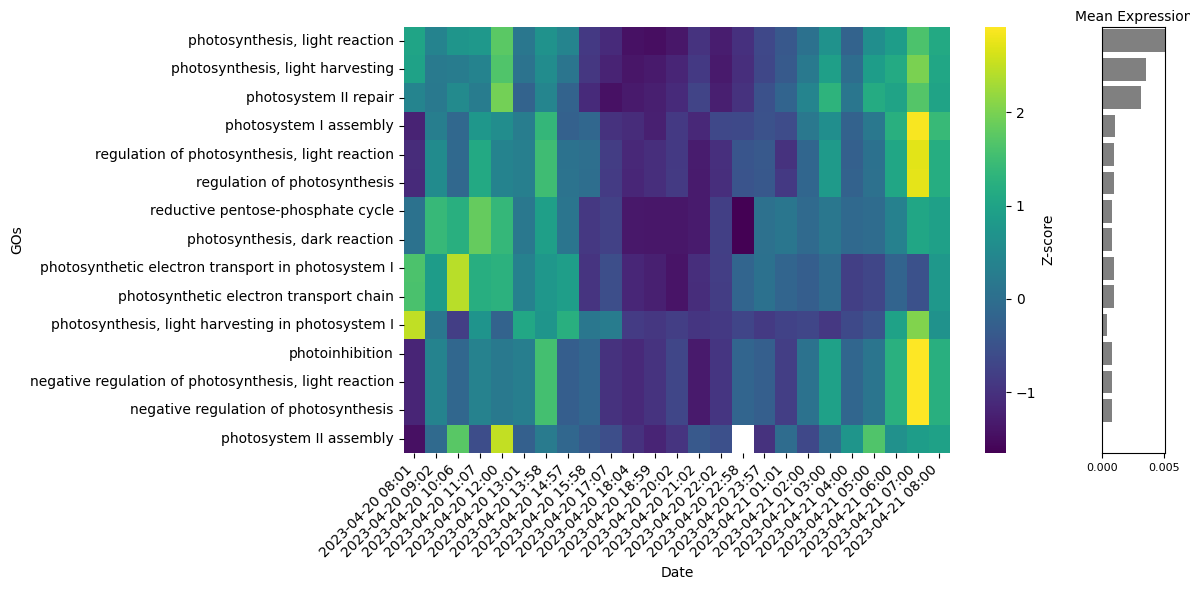

In [65]:
# Calculate mean expression for each GO term
mean_expression = pivoted_expression.mean(axis=1)

# Z-score normalize the expression data
zscore = lambda x: (x - x.mean()) / x.std()
pivoted_expression_zscore = pivoted_expression.apply(zscore, axis=1)

# Only retain the top 50 GO slim categories with the most expression variance
top_terms = pivoted_expression.var(axis=1).sort_values(ascending=False).index[:50]
pivoted_expression_zscore = pivoted_expression_zscore.loc[top_terms]
mean_expression = mean_expression.loc[top_terms]  # Align mean_expression with selected terms

# Set up the figure
fig = plt.figure(figsize=(12, 6))
heatmap_ax = plt.subplot2grid((1, 10), (0, 0), colspan=9)
side_ax = plt.subplot2grid((1, 10), (0, 9), colspan=1, sharey=heatmap_ax)

# Plot the heatmap
sns.heatmap(
    pivoted_expression_zscore,
    cmap='viridis',
    ax=heatmap_ax,
    cbar_kws={'label': 'Z-score'}
)

# Get heatmap y-ticks for alignment
yticks = heatmap_ax.get_yticks()

# Plot the side bar for mean expression
side_ax.barh(
    yticks,
    mean_expression,
    color='gray',
    align='center'
)

# Adjust x-axis for the side bar
side_ax.set_xlim([0, mean_expression.max()])
side_ax.set_xlabel('Mean Expression', fontsize=10)
side_ax.xaxis.set_label_position('top')  # Place label on top
side_ax.tick_params(axis='x', labelsize=8)

# Remove the y-axis for the side bar to avoid duplicate labels
side_ax.yaxis.set_visible(False)

# Format the x-axis ticks to show the date and hour
heatmap_ax.set_xticklabels(
    pivoted_expression.columns.strftime('%Y-%m-%d %H:%M'),
    rotation=45,
    ha='right'
)

# Set y-axis labels on the heatmap to match the GO terms
heatmap_ax.set_yticklabels(pivoted_expression_zscore.index, rotation=0)

# Final adjustments
plt.tight_layout()
plt.show()

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_90538/2023216442.py:75: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


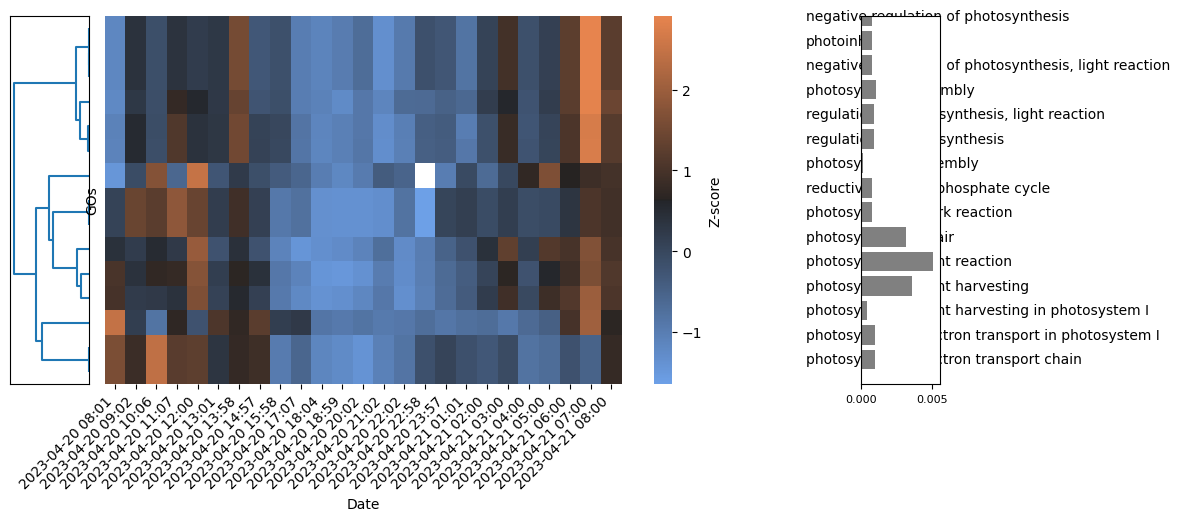

In [66]:
# Perform hierarchical clustering on the Z-score normalized data
row_linkage = linkage(pivoted_expression_zscore.fillna(0), method='ward')

# Get the ordered row indices from the dendrogram
row_order = leaves_list(row_linkage)

# Reorder the rows in the heatmap and mean expression based on the clustering
pivoted_expression_zscore = pivoted_expression_zscore.iloc[row_order]
mean_expression = mean_expression.iloc[row_order]

# Set up the figure with additional space for GO labels
fig = plt.figure(figsize=(12, 6))
dendro_ax = plt.subplot2grid((10, 10), (2, 0), colspan=1, rowspan=8)  # Dendrogram on the left
heatmap_ax = plt.subplot2grid((10, 10), (2, 1), colspan=7, rowspan=8)  # Heatmap
labels_ax = plt.subplot2grid((10, 10), (2, 8), colspan=1, rowspan=8, sharey=heatmap_ax)  # GO labels
side_ax = plt.subplot2grid((10, 10), (2, 9), colspan=1, rowspan=8, sharey=heatmap_ax)  # Sidebar

# Plot the dendrogram
dendrogram(
    row_linkage, 
    ax=dendro_ax, 
    orientation='left', 
    labels=pivoted_expression_zscore.index,
    color_threshold=0  # Optional: Remove colors for clarity
)
dendro_ax.invert_yaxis()  # Align the dendrogram order with the heatmap
dendro_ax.set_xticks([])  # Hide x-ticks
dendro_ax.set_yticks([])  # Hide y-ticks

cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)

# Plot the heatmap
sns.heatmap(
    pivoted_expression_zscore,
    cmap=cmap,
    ax=heatmap_ax,
    cbar_kws={'label': 'Z-score'}
)

# Plot the GO labels
labels_ax.set_xlim(0, 1)  # Arbitrary x-range for text alignment
labels_ax.set_xticks([])  # Remove x-ticks
labels_ax.set_yticks([])  # Remove y-ticks
for i, label in enumerate(pivoted_expression_zscore.index):
    labels_ax.text(0.5, i, label, ha='left', va='center', fontsize=10)
labels_ax.set_axis_off()  # Hide the axis for cleaner appearance

# Plot the sidebar for mean expression
yticks = range(len(mean_expression))  # Align y-ticks with the number of rows

side_ax.barh(
    yticks,
    mean_expression,
    color='gray',
    align='center'
)

# Adjust x-axis for the sidebar
side_ax.set_xlim([0, mean_expression.max() * 1.1])
side_ax.set_xlabel(None)
side_ax.xaxis.set_label_position('top')  # Place label on top
side_ax.tick_params(axis='x', labelsize=8)

# Remove the y-axis for the sidebar to avoid duplicate labels
side_ax.yaxis.set_visible(False)

# Format the x-axis ticks to show the date and hour
heatmap_ax.set_xticklabels(
    pivoted_expression.columns.strftime('%Y-%m-%d %H:%M'),
    rotation=45,
    ha='right'
)

# Final adjustments
plt.tight_layout()
# Save the figure as a SVG file
plt.savefig('../figures/metatranscriptomics/pathway_analysis/photosynthesis_GOs_heatmap.svg')

plt.show()

### Correlation of GO expression

In [67]:
# Filter dataset by extracted terms
filtered_data = data_exploded[data_exploded['GOs'].isin(selected_GOs)]

grouped_expression = filtered_data.groupby(['GOs', 'sample'])['TPL_standardized'].sum().reset_index()

# Replace 0 with NaN in the log-transformed TPL values to interrupt the heatmap
grouped_expression.replace(0, np.nan, inplace=True)

# Merge GO_slim expression with env_data to include the Date column
grouped_expression_with_date = grouped_expression.reset_index().merge(env_data[['sample', 'Date']], on='sample', how='left')

# Convert the Date column to datetime format for proper plotting
grouped_expression_with_date['Date'] = pd.to_datetime(grouped_expression_with_date['Date'])

# Sort the dataframe by Date for better visualization
grouped_expression_with_date = grouped_expression_with_date.sort_values(by='Date')

# Add hours since start for regression analysis downstream
grouped_expression_with_date['hours_since_start'] = (grouped_expression_with_date['Date'] - grouped_expression_with_date['Date'].min()).dt.total_seconds() / 3600

# Pivot the data for heatmap plotting
pivoted_expression = grouped_expression_with_date.pivot(index='GOs', columns='Date', values='TPL_standardized')

# Create a mapping of GO IDs to names
go_id_to_name = {go_id: go_dag[go_id].name for go_id in pivoted_expression.index if go_id in go_dag}

# Replace the index in pivoted_expression with GO names
pivoted_expression = pivoted_expression.rename(index=go_id_to_name)

# Calculate mean expression for each GO term
mean_expression = pivoted_expression.mean(axis=1)

# Z-score normalize the expression data
zscore = lambda x: (x - x.mean()) / x.std()
pivoted_expression_zscore = pivoted_expression.apply(zscore, axis=1)

# Perform hierarchical clustering on the Z-score normalized data
row_linkage = linkage(pivoted_expression_zscore.fillna(0), method='ward')

# Get the ordered row indices from the dendrogram
row_order = leaves_list(row_linkage)

# Reorder the rows in the heatmap and mean expression based on the clustering
pivoted_expression_zscore = pivoted_expression_zscore.iloc[row_order]

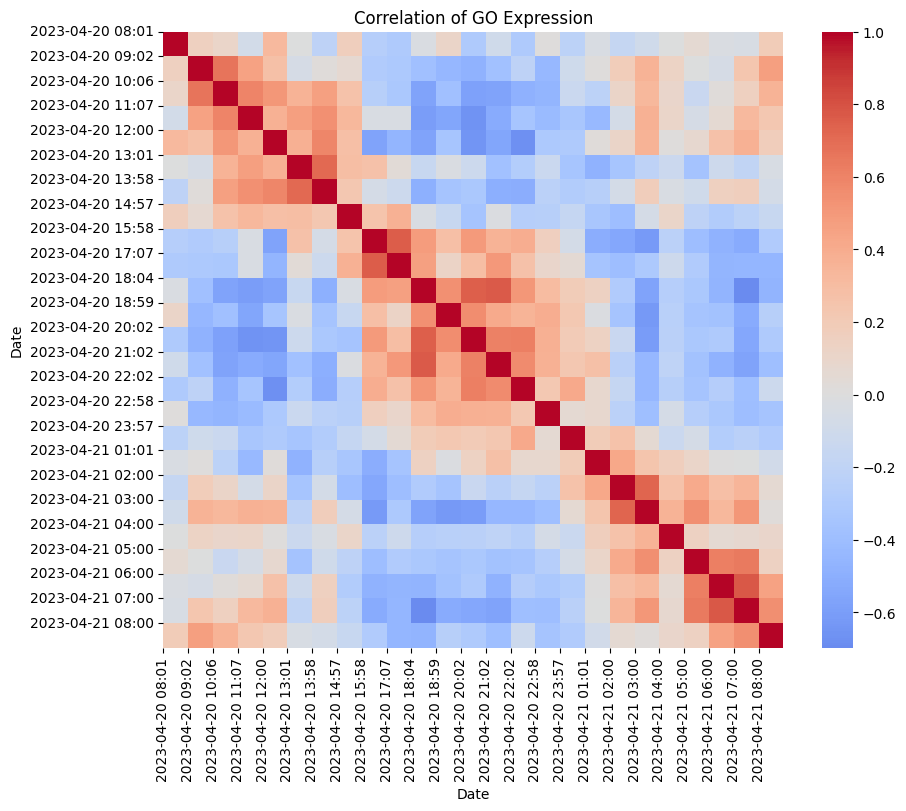

In [68]:
# Plot the correlation of the samples based on the GO slim categories
plt.figure(figsize=(10, 8))
sns.heatmap(pivoted_expression_zscore.corr(), cmap='coolwarm', center=0)
plt.title('Correlation of GO Expression')
# Format the x-axis ticks to show the date and hour
plt.xticks(ticks=range(len(grouped_expression_with_date['Date'].unique())), labels=grouped_expression_with_date['Date'].unique().strftime('%Y-%m-%d %H:%M'))
plt.yticks(ticks=range(len(grouped_expression_with_date['Date'].unique())), labels=grouped_expression_with_date['Date'].unique().strftime('%Y-%m-%d %H:%M'))

# Save the figure as a SVG file
plt.savefig('../figures/metatranscriptomics/pathway_analysis/GO_expression_correlation_across_samples.svg', format='svg', bbox_inches='tight', dpi=800)
plt.savefig('../figures/metatranscriptomics/pathway_analysis/GO_expression_correlation_across_samples.png', format='png', bbox_inches='tight', dpi=800)
plt.show()

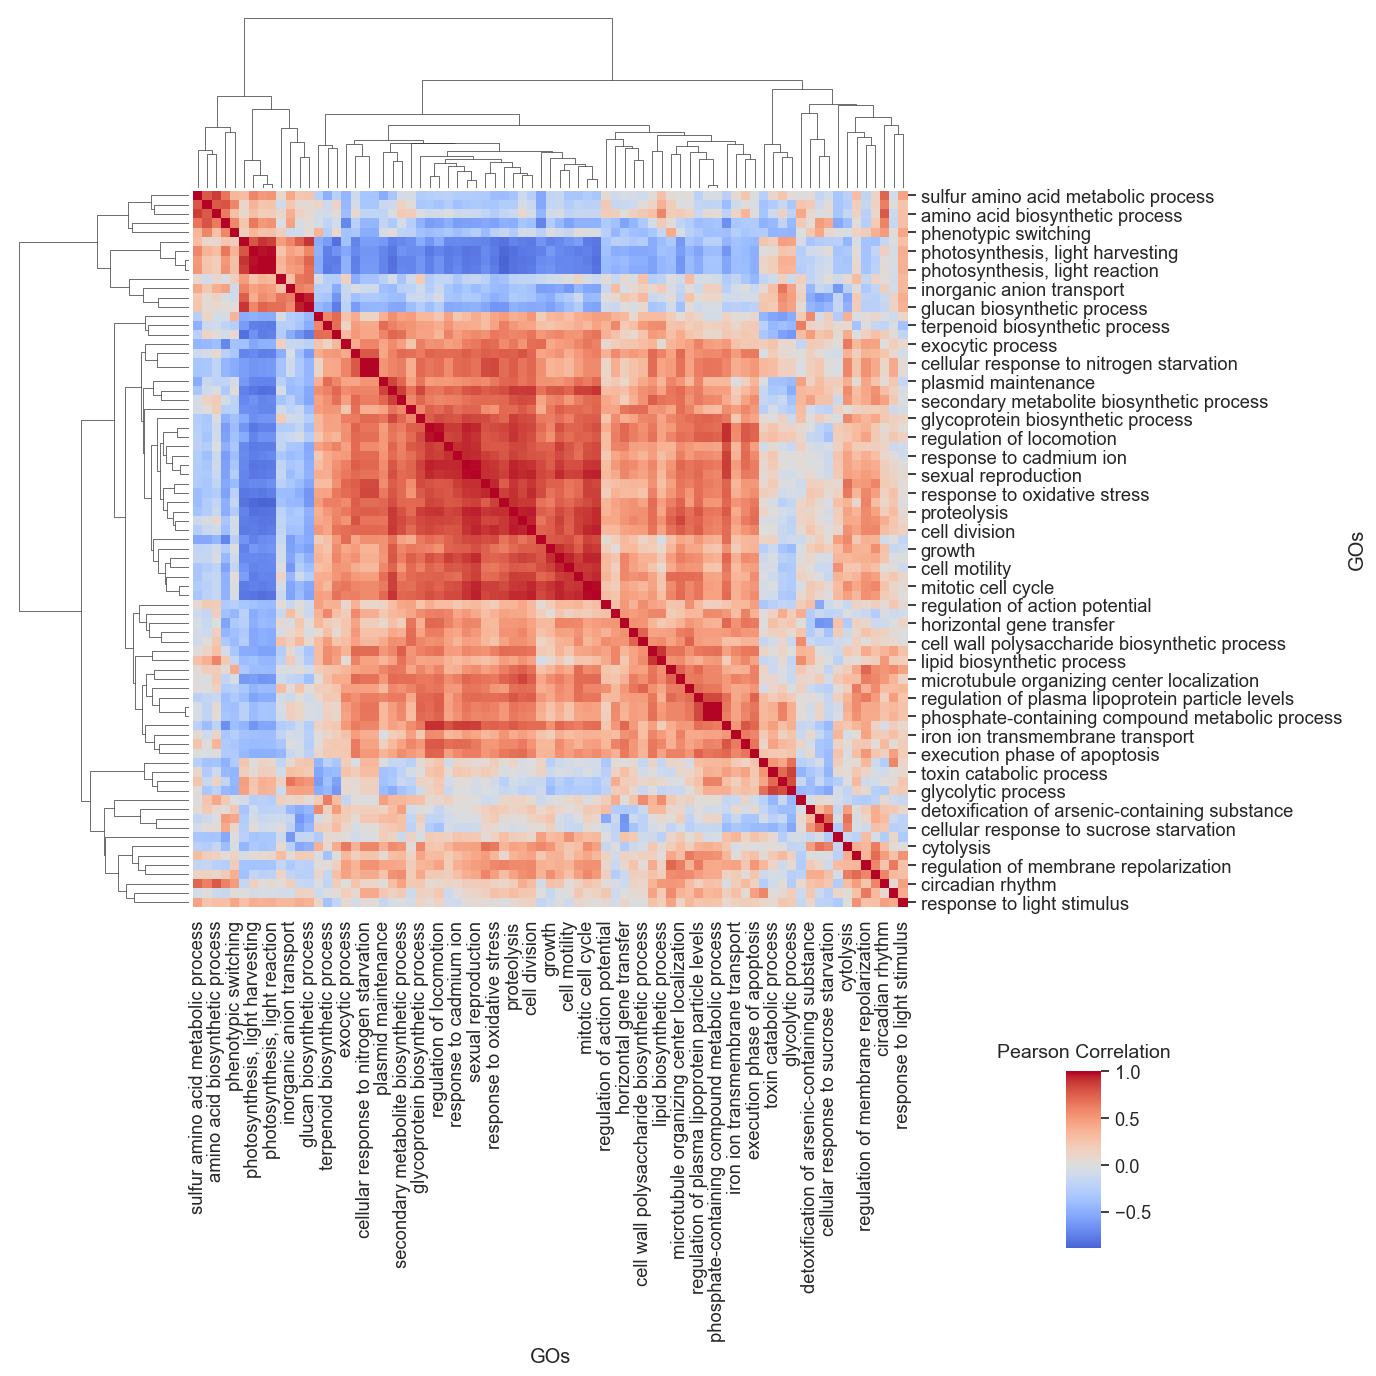

In [69]:
# Plot the correlation between expression of GO slim categories
sns.set(font_scale=1.2)

# Compute the correlation matrix
correlation_matrix = pivoted_expression_zscore.T.corr()

# Create the clustermap
kws = dict(figsize=(14, 14))
g = sns.clustermap(correlation_matrix, cmap='coolwarm', center=0, **kws)

# Adjust the colorbar position
x0, y0, width, height = g.cbar_pos
g.ax_cbar.set_position([x0 + 0.75, y0 - 0.7, width * 0.5, height * 0.7])  # Adjust to lower right
g.ax_cbar.set_title('Pearson Correlation', fontsize=14, pad=10)  # Adjust title padding with `pad`
g.ax_cbar.tick_params(axis='x', length=5)  # Adjust tick length

# Save the figure as a SVG file
plt.savefig('../figures/metatranscriptomics/pathway_analysis/GO_expression_correlation_across_categories.svg', format='svg', bbox_inches='tight', dpi=800)
plt.savefig('../figures/metatranscriptomics/pathway_analysis/GO_expression_correlation_across_categories.png', format='png', bbox_inches='tight', dpi=800)
plt.show()